In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (specific humidity) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (specific humidity) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (specific humidity) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (specific humidity) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 10
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)

#Since the NaN values of GHI are gone which is used in data preparation, simulate these in solar activity instead
df['solar_activity'].loc[df['Year'] > 2020] = np.nan
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when GHI is removed as a predictor
df_trimmed = df_trimmed.drop(['GHI'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 15
n_seq (number of output/future prediction time steps): 10
C:\Users\User
C:\Users\User\Modeling\
     file_id        date  specific_humidity          slp  vapor_pressure  \
0       6678  1998-12-31          12.816968  1016.202508       20.726068   
1       6678  1999-12-31          12.330412  1017.480181       19.960131   
2       6678  2000-12-31          12.136613  1018.259826       19.655271   
3       6678  2001-12-31          11.897962  1018.414173       19.285320   
4       6678  2002-12-31          12.751085  1017.916636       20.638060   
..       ...         ...                ...          ...             ...   
643     8000  2020-12-31           5.146134  1016.944161        8.168785   
644     8000  2021-12-31           5.239193  1016.159983        8.312383   
645     8000  2022-12-31           5.362553  1017.898453        8.512894   
646     8000  2023-12-31           5.430746  1016.166709        8.612808   
647     800

C:\Users\User\AppData\Local\Temp\ipykernel_593168\3928144109.py:409: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['solar_activity'].loc[df['Year'] > 2020] = np.nan


     file_id  specific_humidity      slp  wet_bulb_temperature  temperatures  \
0       6678              12.82  1016.20                 18.08         20.84   
1       6678              12.33  1017.48                 17.71         20.69   
2       6678              12.14  1018.26                 17.29         20.47   
3       6678              11.90  1018.41                 17.20         20.30   
4       6678              12.75  1017.92                 17.75         20.46   
..       ...                ...      ...                   ...           ...   
643     8000               5.15  1016.94                  7.64         13.02   
644     8000               5.24  1016.16                  7.88         13.47   
645     8000               5.36  1017.90                  7.13         11.84   
646     8000               5.43  1016.17                  7.66         12.86   
647     8000               5.32  1015.12                  8.11         13.58   

     water      WDSP  PRCP  SNDP  regio

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

10
15
(19, 175)
(2, 175)


[I 2025-06-07 18:56:00,641] A new study created in memory with name: no-name-d117c470-9457-4675-98e8-fc18ef3b1bb7
[I 2025-06-07 18:57:53,785] Trial 0 finished with value: 0.10897097885608673 and parameters: {'lr': 0.3693388846841874, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2437900974903192}. Best is trial 0 with value: 0.10897097885608673.


Cross Validation Accuracies:
[0.10325634479522705, 0.12428320944309235, 0.11206222325563431, 0.11691715568304062, 0.08833596110343933]
Mean Cross Validation Accuracy:
0.10897097885608673
Standard Deviation of Cross Validation Accuracy:
0.012374351892153338


[I 2025-06-07 19:00:14,985] Trial 1 finished with value: 0.09006847590208053 and parameters: {'lr': 0.014030423295325667, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.13553579543458918}. Best is trial 1 with value: 0.09006847590208053.


Cross Validation Accuracies:
[0.0944247618317604, 0.09331151843070984, 0.08440413326025009, 0.10538151115179062, 0.07282045483589172]
Mean Cross Validation Accuracy:
0.09006847590208053
Standard Deviation of Cross Validation Accuracy:
0.010895527603253002


[I 2025-06-07 19:02:21,238] Trial 2 finished with value: 0.08897145539522171 and parameters: {'lr': 0.010181400115082494, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1256687766591388}. Best is trial 2 with value: 0.08897145539522171.


Cross Validation Accuracies:
[0.09260959178209305, 0.09310655295848846, 0.08391403406858444, 0.10325264185667038, 0.07197445631027222]
Mean Cross Validation Accuracy:
0.08897145539522171
Standard Deviation of Cross Validation Accuracy:
0.010476286015022462


[I 2025-06-07 19:05:24,479] Trial 3 finished with value: 1.1119247913360595 and parameters: {'lr': 0.17059495491611817, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.31250728338706557}. Best is trial 2 with value: 0.08897145539522171.


Cross Validation Accuracies:
[1.2964110374450684, 1.0916744470596313, 1.1729189157485962, 0.9721196889877319, 1.02649986743927]
Mean Cross Validation Accuracy:
1.1119247913360595
Standard Deviation of Cross Validation Accuracy:
0.11402492615648412


[I 2025-06-07 19:09:21,763] Trial 4 finished with value: 0.08917931765317917 and parameters: {'lr': 0.013272855694196017, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.4756237375002764}. Best is trial 2 with value: 0.08897145539522171.


Cross Validation Accuracies:
[0.09325990825891495, 0.09179581701755524, 0.08446215838193893, 0.1048540472984314, 0.07152465730905533]
Mean Cross Validation Accuracy:
0.08917931765317917
Standard Deviation of Cross Validation Accuracy:
0.010983014718407465


[I 2025-06-07 19:15:16,493] Trial 5 finished with value: 0.08627618402242661 and parameters: {'lr': 0.0016806998295272968, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.22292459883663238}. Best is trial 5 with value: 0.08627618402242661.


Cross Validation Accuracies:
[0.08652748912572861, 0.09084393829107285, 0.07960328459739685, 0.10040144622325897, 0.07400476187467575]
Mean Cross Validation Accuracy:
0.08627618402242661
Standard Deviation of Cross Validation Accuracy:
0.009116643612874398


[I 2025-06-07 19:19:41,132] Trial 6 finished with value: 0.08847055733203887 and parameters: {'lr': 0.07307101165755057, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.31736567976512103}. Best is trial 5 with value: 0.08627618402242661.


Cross Validation Accuracies:
[0.09199273586273193, 0.09046109765768051, 0.0826733410358429, 0.10504301637411118, 0.07218259572982788]
Mean Cross Validation Accuracy:
0.08847055733203887
Standard Deviation of Cross Validation Accuracy:
0.010862042174759078


[I 2025-06-07 19:25:26,383] Trial 7 finished with value: 0.09513911753892898 and parameters: {'lr': 0.0780555302973975, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.41345611229550816}. Best is trial 5 with value: 0.08627618402242661.


Cross Validation Accuracies:
[0.08721943944692612, 0.09755615144968033, 0.08657652884721756, 0.11259090900421143, 0.0917525589466095]
Mean Cross Validation Accuracy:
0.09513911753892898
Standard Deviation of Cross Validation Accuracy:
0.009569901604060667


[I 2025-06-07 19:30:43,322] Trial 8 finished with value: 7.811196136474609 and parameters: {'lr': 0.08431060475531268, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.47494520630233394}. Best is trial 5 with value: 0.08627618402242661.


Cross Validation Accuracies:
[7.794838905334473, 5.360807418823242, 8.920985221862793, 8.823007583618164, 8.156341552734375]
Mean Cross Validation Accuracy:
7.811196136474609
Standard Deviation of Cross Validation Accuracy:
1.2945417724883415


[I 2025-06-07 19:35:18,959] Trial 9 finished with value: 0.2061030685901642 and parameters: {'lr': 0.08020289115496361, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.19845903094559542}. Best is trial 5 with value: 0.08627618402242661.


Cross Validation Accuracies:
[0.2124391794204712, 0.19968023896217346, 0.21068595349788666, 0.1991669237613678, 0.20854304730892181]
Mean Cross Validation Accuracy:
0.2061030685901642
Standard Deviation of Cross Validation Accuracy:
0.0055940231711280675


[I 2025-06-07 19:41:05,071] Trial 10 finished with value: 0.08564805388450622 and parameters: {'lr': 0.0014264693067028453, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.23480384233547757}. Best is trial 10 with value: 0.08564805388450622.


Cross Validation Accuracies:
[0.08231628686189651, 0.09715843200683594, 0.08103050291538239, 0.10321421176195145, 0.06452083587646484]
Mean Cross Validation Accuracy:
0.08564805388450622
Standard Deviation of Cross Validation Accuracy:
0.013563484038395529


[I 2025-06-07 19:47:10,481] Trial 11 finished with value: 0.0877097263932228 and parameters: {'lr': 0.0011417863489409164, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.22440140862348407}. Best is trial 10 with value: 0.08564805388450622.


Cross Validation Accuracies:
[0.09282578527927399, 0.09321201592683792, 0.0774153470993042, 0.1003180593252182, 0.07477742433547974]
Mean Cross Validation Accuracy:
0.0877097263932228
Standard Deviation of Cross Validation Accuracy:
0.009885726979044879


[I 2025-06-07 19:53:25,090] Trial 12 finished with value: 0.08787524849176406 and parameters: {'lr': 0.0014630704832716496, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2758640963190579}. Best is trial 10 with value: 0.08564805388450622.


Cross Validation Accuracies:
[0.09002844244241714, 0.09239581227302551, 0.07378982752561569, 0.10687663406133652, 0.07628552615642548]
Mean Cross Validation Accuracy:
0.08787524849176406
Standard Deviation of Cross Validation Accuracy:
0.011990372323301695


[I 2025-06-07 19:59:58,608] Trial 13 finished with value: 0.08235803693532943 and parameters: {'lr': 0.0037251814036925067, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.17976687186480517}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.07891116291284561, 0.08736024051904678, 0.077217236161232, 0.09308330714702606, 0.07521823793649673]
Mean Cross Validation Accuracy:
0.08235803693532943
Standard Deviation of Cross Validation Accuracy:
0.006772576535948912


[I 2025-06-07 20:07:00,856] Trial 14 finished with value: 0.08826580345630645 and parameters: {'lr': 0.005730026830545396, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.16826592529196147}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.09278877824544907, 0.09238283336162567, 0.08398561924695969, 0.09965386241674423, 0.07251792401075363]
Mean Cross Validation Accuracy:
0.08826580345630645
Standard Deviation of Cross Validation Accuracy:
0.009310325525657264


[I 2025-06-07 20:13:47,028] Trial 15 finished with value: 0.11586945056915283 and parameters: {'lr': 0.0035394227630941447, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.36123362277061943}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.11490917205810547, 0.11871565878391266, 0.08736675977706909, 0.16971726715564728, 0.08863839507102966]
Mean Cross Validation Accuracy:
0.11586945056915283
Standard Deviation of Cross Validation Accuracy:
0.0298748862862582


[I 2025-06-07 20:20:32,668] Trial 16 finished with value: 0.08772604614496231 and parameters: {'lr': 0.0033720190296722, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.10074562014893927}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.08381594717502594, 0.0971326157450676, 0.08164425939321518, 0.10325074940919876, 0.07278665900230408]
Mean Cross Validation Accuracy:
0.08772604614496231
Standard Deviation of Cross Validation Accuracy:
0.010999656861292222


[I 2025-06-07 20:27:17,195] Trial 17 finished with value: 0.08890793472528458 and parameters: {'lr': 0.02358190325982322, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.18005330766932237}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.09048066288232803, 0.09213127940893173, 0.08565294742584229, 0.10495781898498535, 0.07131696492433548]
Mean Cross Validation Accuracy:
0.08890793472528458
Standard Deviation of Cross Validation Accuracy:
0.010867376596150316


[I 2025-06-07 20:34:03,784] Trial 18 finished with value: 0.4157669126987457 and parameters: {'lr': 0.003027660918453149, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2684300942660024}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.38357454538345337, 0.3858981728553772, 0.35439348220825195, 0.5671542286872864, 0.38781413435935974]
Mean Cross Validation Accuracy:
0.4157669126987457
Standard Deviation of Cross Validation Accuracy:
0.07667420082722755


[I 2025-06-07 20:41:27,408] Trial 19 finished with value: 0.1231596976518631 and parameters: {'lr': 0.0076495371974874765, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.3434473053736173}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.1400483101606369, 0.100169338285923, 0.09404809772968292, 0.11729798465967178, 0.16423475742340088]
Mean Cross Validation Accuracy:
0.1231596976518631
Standard Deviation of Cross Validation Accuracy:
0.026010718255034353


[I 2025-06-07 20:47:32,197] Trial 20 finished with value: 0.08818730860948562 and parameters: {'lr': 0.0010009426911632706, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.16235680151934664}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.09189233183860779, 0.09036511182785034, 0.08302789181470871, 0.10368925333023071, 0.07196195423603058]
Mean Cross Validation Accuracy:
0.08818730860948562
Standard Deviation of Cross Validation Accuracy:
0.010475323577987593


[I 2025-06-07 20:54:14,768] Trial 21 finished with value: 0.08569009006023406 and parameters: {'lr': 0.0020739389647424925, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.23725795347160789}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.08509503304958344, 0.09262552112340927, 0.0752343237400055, 0.10407213866710663, 0.07142343372106552]
Mean Cross Validation Accuracy:
0.08569009006023406
Standard Deviation of Cross Validation Accuracy:
0.011825519356937942


[I 2025-06-07 21:00:57,281] Trial 22 finished with value: 0.08246701657772064 and parameters: {'lr': 0.0034517892458303906, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2469858611964101}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.07380349189043045, 0.09164820611476898, 0.07577391713857651, 0.10196913778781891, 0.06914032995700836]
Mean Cross Validation Accuracy:
0.08246701657772064
Standard Deviation of Cross Validation Accuracy:
0.012345702000330321


[I 2025-06-07 21:07:27,396] Trial 23 finished with value: 0.08357115983963012 and parameters: {'lr': 0.004864932452531719, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1992568113739513}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.07597669959068298, 0.09283767640590668, 0.07901463657617569, 0.09767887741327286, 0.07234790921211243]
Mean Cross Validation Accuracy:
0.08357115983963012
Standard Deviation of Cross Validation Accuracy:
0.009892371907505923


[I 2025-06-07 21:14:21,630] Trial 24 finished with value: 0.08948865979909897 and parameters: {'lr': 0.029954660464614032, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2049547350418771}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.09384535998106003, 0.09278886020183563, 0.08363720029592514, 0.10588955134153366, 0.07128232717514038]
Mean Cross Validation Accuracy:
0.08948865979909897
Standard Deviation of Cross Validation Accuracy:
0.011528846676853072


[I 2025-06-07 21:21:11,916] Trial 25 finished with value: 0.08621304631233215 and parameters: {'lr': 0.003650130716099338, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2837364660409698}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.0884564071893692, 0.09004153311252594, 0.07866331934928894, 0.10046008229255676, 0.07344388961791992]
Mean Cross Validation Accuracy:
0.08621304631233215
Standard Deviation of Cross Validation Accuracy:
0.009409758268187844


[I 2025-06-07 21:27:57,715] Trial 26 finished with value: 0.08867820948362351 and parameters: {'lr': 0.005864994711042854, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1388723902296979}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.0921911671757698, 0.09187067300081253, 0.07475006580352783, 0.10537254065275192, 0.07920660078525543]
Mean Cross Validation Accuracy:
0.08867820948362351
Standard Deviation of Cross Validation Accuracy:
0.010816080121266818


[I 2025-06-07 21:34:48,503] Trial 27 finished with value: 0.09140044599771499 and parameters: {'lr': 0.01712794123131794, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.19157379266578273}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.09111890941858292, 0.09710999578237534, 0.08823374658823013, 0.10853822529315948, 0.07200135290622711]
Mean Cross Validation Accuracy:
0.09140044599771499
Standard Deviation of Cross Validation Accuracy:
0.011939300638567695


[I 2025-06-07 21:42:17,036] Trial 28 finished with value: 0.1532478526234627 and parameters: {'lr': 0.007758200475596759, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.15677579530591101}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.15927202999591827, 0.1913200169801712, 0.14301931858062744, 0.12217912822961807, 0.1504487693309784]
Mean Cross Validation Accuracy:
0.1532478526234627
Standard Deviation of Cross Validation Accuracy:
0.02264289656039356


[I 2025-06-07 21:48:17,631] Trial 29 finished with value: 0.0921685054898262 and parameters: {'lr': 0.5019118217694786, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2625374491334764}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.08847622573375702, 0.0960845872759819, 0.08099489659070969, 0.11020080745220184, 0.08508601039648056]
Mean Cross Validation Accuracy:
0.0921685054898262
Standard Deviation of Cross Validation Accuracy:
0.010287310756392226


[I 2025-06-07 21:54:50,930] Trial 30 finished with value: 0.336379474401474 and parameters: {'lr': 0.0024329200235303147, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.10157167144893611}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.29302307963371277, 0.2837291955947876, 0.3009440004825592, 0.5082935690879822, 0.29590752720832825]
Mean Cross Validation Accuracy:
0.336379474401474
Standard Deviation of Cross Validation Accuracy:
0.08613934768620474


[I 2025-06-07 22:01:26,302] Trial 31 finished with value: 0.0880681812763214 and parameters: {'lr': 0.0049839394542695314, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.24590230959671808}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.08572707325220108, 0.09249638766050339, 0.07775096595287323, 0.11226556450128555, 0.0721009150147438]
Mean Cross Validation Accuracy:
0.0880681812763214
Standard Deviation of Cross Validation Accuracy:
0.013942752076945177


[I 2025-06-07 22:07:24,041] Trial 32 finished with value: 0.08754649758338928 and parameters: {'lr': 0.0014139346600735893, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.20955268587655432}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.08331158757209778, 0.09662739187479019, 0.06843510270118713, 0.10367848724126816, 0.08567991852760315]
Mean Cross Validation Accuracy:
0.08754649758338928
Standard Deviation of Cross Validation Accuracy:
0.012077812102961426


[I 2025-06-07 22:13:25,389] Trial 33 finished with value: 0.0967748299241066 and parameters: {'lr': 0.963394567117109, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.24408872953974836}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.12812776863574982, 0.0921790674328804, 0.08784467726945877, 0.10451539605855942, 0.07120724022388458]
Mean Cross Validation Accuracy:
0.0967748299241066
Standard Deviation of Cross Validation Accuracy:
0.018960450587092427


[I 2025-06-07 22:20:27,799] Trial 34 finished with value: 0.09034415930509568 and parameters: {'lr': 0.010438933265179876, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.29991142820349453}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.09696420282125473, 0.09476138651371002, 0.08213933557271957, 0.1049862653017044, 0.07286960631608963]
Mean Cross Validation Accuracy:
0.09034415930509568
Standard Deviation of Cross Validation Accuracy:
0.011405325729931873


[I 2025-06-07 22:26:09,998] Trial 35 finished with value: 0.08857611864805222 and parameters: {'lr': 0.0022777322382719727, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.1429714652306873}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.09182914346456528, 0.09219736605882645, 0.08359406888484955, 0.1045714020729065, 0.07068861275911331]
Mean Cross Validation Accuracy:
0.08857611864805222
Standard Deviation of Cross Validation Accuracy:
0.011174331137729528


[I 2025-06-07 22:32:38,841] Trial 36 finished with value: 0.08959502726793289 and parameters: {'lr': 0.004948783563658264, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.18700249538543548}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.09231743216514587, 0.09149075299501419, 0.08461012691259384, 0.10496357828378677, 0.07459324598312378]
Mean Cross Validation Accuracy:
0.08959502726793289
Standard Deviation of Cross Validation Accuracy:
0.009970960816827022


[I 2025-06-07 22:39:09,431] Trial 37 finished with value: 0.08309588432312012 and parameters: {'lr': 0.00180436747120182, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2219219423273307}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.07015194743871689, 0.093388631939888, 0.0771261528134346, 0.1041894406080246, 0.0706232488155365]
Mean Cross Validation Accuracy:
0.08309588432312012
Standard Deviation of Cross Validation Accuracy:
0.013487984305426044


[I 2025-06-07 22:44:15,225] Trial 38 finished with value: 0.18855479061603547 and parameters: {'lr': 0.016102053420682803, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.12383449968455755}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.14950880408287048, 0.14882326126098633, 0.16445451974868774, 0.33848249912261963, 0.14150486886501312]
Mean Cross Validation Accuracy:
0.18855479061603547
Standard Deviation of Cross Validation Accuracy:
0.07533394913308522


[I 2025-06-07 22:51:12,818] Trial 39 finished with value: 0.30196644067764283 and parameters: {'lr': 0.045085341607184096, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.25321115015969115}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.15259632468223572, 0.24437865614891052, 0.37915122509002686, 0.31048861145973206, 0.42321738600730896]
Mean Cross Validation Accuracy:
0.30196644067764283
Standard Deviation of Cross Validation Accuracy:
0.09629090773522914


[I 2025-06-07 22:56:18,479] Trial 40 finished with value: 0.089257350564003 and parameters: {'lr': 0.009214721304982187, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.2129037954385661}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.09122680872678757, 0.09226959198713303, 0.08389756828546524, 0.10661081224679947, 0.07228197157382965]
Mean Cross Validation Accuracy:
0.089257350564003
Standard Deviation of Cross Validation Accuracy:
0.011233750523808251


[I 2025-06-07 23:02:13,554] Trial 41 finished with value: 0.0859848529100418 and parameters: {'lr': 0.0015968655636271801, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.23260394992725086}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.0901428759098053, 0.08886896073818207, 0.07997196912765503, 0.09225155413150787, 0.07868890464305878]
Mean Cross Validation Accuracy:
0.0859848529100418
Standard Deviation of Cross Validation Accuracy:
0.005554537063068515


[I 2025-06-07 23:08:35,092] Trial 42 finished with value: 0.0871440276503563 and parameters: {'lr': 0.0021728668293899017, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.21951153409734225}. Best is trial 13 with value: 0.08235803693532943.


Cross Validation Accuracies:
[0.09089849889278412, 0.09351228177547455, 0.07512295991182327, 0.10365857928991318, 0.07252781838178635]
Mean Cross Validation Accuracy:
0.0871440276503563
Standard Deviation of Cross Validation Accuracy:
0.01170914833559575


[I 2025-06-07 23:14:41,837] Trial 43 finished with value: 0.08196010291576386 and parameters: {'lr': 0.004104148410403209, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3036855386753068}. Best is trial 43 with value: 0.08196010291576386.


Cross Validation Accuracies:
[0.07374203205108643, 0.0913235992193222, 0.08133460581302643, 0.09232234954833984, 0.07107792794704437]
Mean Cross Validation Accuracy:
0.08196010291576386
Standard Deviation of Cross Validation Accuracy:
0.008733852365517764


[I 2025-06-07 23:20:41,387] Trial 44 finished with value: 0.08942003399133683 and parameters: {'lr': 0.004111184857315454, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3157116128081375}. Best is trial 43 with value: 0.08196010291576386.


Cross Validation Accuracies:
[0.10071449726819992, 0.08980947732925415, 0.08535996079444885, 0.100405752658844, 0.0708104819059372]
Mean Cross Validation Accuracy:
0.08942003399133683
Standard Deviation of Cross Validation Accuracy:
0.011056239909216538


[I 2025-06-07 23:25:53,645] Trial 45 finished with value: 2.6899389743804933 and parameters: {'lr': 0.18876765451369534, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.351828016487452}. Best is trial 43 with value: 0.08196010291576386.


Cross Validation Accuracies:
[3.2136242389678955, 2.935173749923706, 2.1242048740386963, 2.409222364425659, 2.767469644546509]
Mean Cross Validation Accuracy:
2.6899389743804933
Standard Deviation of Cross Validation Accuracy:
0.3845137822477046


[I 2025-06-07 23:32:03,779] Trial 46 finished with value: 0.09010241627693176 and parameters: {'lr': 0.010449690894894734, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.29740693844623184}. Best is trial 43 with value: 0.08196010291576386.


Cross Validation Accuracies:
[0.09195081144571304, 0.09474270790815353, 0.08599159121513367, 0.10501979291439056, 0.072807177901268]
Mean Cross Validation Accuracy:
0.09010241627693176
Standard Deviation of Cross Validation Accuracy:
0.010616036454593606


[I 2025-06-07 23:38:26,247] Trial 47 finished with value: 0.08828461319208145 and parameters: {'lr': 0.005949144274892016, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.4267020216282742}. Best is trial 43 with value: 0.08196010291576386.


Cross Validation Accuracies:
[0.09072312712669373, 0.09422643482685089, 0.08358482271432877, 0.10101928561925888, 0.071869395673275]
Mean Cross Validation Accuracy:
0.08828461319208145
Standard Deviation of Cross Validation Accuracy:
0.00994958163040769


[I 2025-06-07 23:44:06,952] Trial 48 finished with value: 0.08653080761432648 and parameters: {'lr': 0.002851076330970205, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.38478435895836494}. Best is trial 43 with value: 0.08196010291576386.


Cross Validation Accuracies:
[0.08439435064792633, 0.0925486832857132, 0.08339980989694595, 0.10285000503063202, 0.06946118921041489]
Mean Cross Validation Accuracy:
0.08653080761432648
Standard Deviation of Cross Validation Accuracy:
0.011029691740382418


[I 2025-06-07 23:50:06,429] Trial 49 finished with value: 0.4487355053424835 and parameters: {'lr': 0.001890678843569952, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.33095082914219887}. Best is trial 43 with value: 0.08196010291576386.


Cross Validation Accuracies:
[0.3969823122024536, 0.4191468060016632, 0.41964036226272583, 0.593681812286377, 0.414226233959198]
Mean Cross Validation Accuracy:
0.4487355053424835
Standard Deviation of Cross Validation Accuracy:
0.0729393353243377


[I 2025-06-07 23:55:43,717] Trial 50 finished with value: 0.08717537820339202 and parameters: {'lr': 0.004188355252265571, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.28041404851950996}. Best is trial 43 with value: 0.08196010291576386.


Cross Validation Accuracies:
[0.0891510620713234, 0.09118566662073135, 0.08047928661108017, 0.10594308376312256, 0.06911779195070267]
Mean Cross Validation Accuracy:
0.08717537820339202
Standard Deviation of Cross Validation Accuracy:
0.012191198265953482


[I 2025-06-08 00:01:56,544] Trial 51 finished with value: 0.08344534933567047 and parameters: {'lr': 0.0012210298064359419, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1821656776336245}. Best is trial 43 with value: 0.08196010291576386.


Cross Validation Accuracies:
[0.07881488651037216, 0.09443110972642899, 0.08052103966474533, 0.09492864459753036, 0.06853106617927551]
Mean Cross Validation Accuracy:
0.08344534933567047
Standard Deviation of Cross Validation Accuracy:
0.010049692697105468


[I 2025-06-08 00:08:09,604] Trial 52 finished with value: 0.08143496364355088 and parameters: {'lr': 0.0011818602420903578, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.17828033129751508}. Best is trial 52 with value: 0.08143496364355088.


Cross Validation Accuracies:
[0.07538712024688721, 0.09021182358264923, 0.07094735652208328, 0.09098303318023682, 0.07964548468589783]
Mean Cross Validation Accuracy:
0.08143496364355088
Standard Deviation of Cross Validation Accuracy:
0.007974552653191887


[I 2025-06-08 00:14:12,738] Trial 53 finished with value: 0.08502963185310364 and parameters: {'lr': 0.0012357012411379628, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.173837140438894}. Best is trial 52 with value: 0.08143496364355088.


Cross Validation Accuracies:
[0.09071273356676102, 0.09351733326911926, 0.07790318876504898, 0.0842759758234024, 0.07873892784118652]
Mean Cross Validation Accuracy:
0.08502963185310364
Standard Deviation of Cross Validation Accuracy:
0.0062492538095223205


[I 2025-06-08 00:19:59,555] Trial 54 finished with value: 0.08283011913299561 and parameters: {'lr': 0.0010189916469527283, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.15931546354947468}. Best is trial 52 with value: 0.08143496364355088.


Cross Validation Accuracies:
[0.0910896360874176, 0.08731932938098907, 0.07428957521915436, 0.09245118498802185, 0.06900086998939514]
Mean Cross Validation Accuracy:
0.08283011913299561
Standard Deviation of Cross Validation Accuracy:
0.009435322563408744


[I 2025-06-08 00:26:19,381] Trial 55 finished with value: 0.1070578083395958 and parameters: {'lr': 0.0010090870046751165, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.15449207252681008}. Best is trial 52 with value: 0.08143496364355088.


Cross Validation Accuracies:
[0.08917149901390076, 0.11448411643505096, 0.1124589741230011, 0.13094332814216614, 0.08823112398386002]
Mean Cross Validation Accuracy:
0.1070578083395958
Standard Deviation of Cross Validation Accuracy:
0.01630463004862351


[I 2025-06-08 00:33:04,795] Trial 56 finished with value: 0.09020785391330718 and parameters: {'lr': 0.0017118139873520133, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.11998661529303956}. Best is trial 52 with value: 0.08143496364355088.


Cross Validation Accuracies:
[0.0959029272198677, 0.09640996903181076, 0.07852286845445633, 0.10234906524419785, 0.07785443961620331]
Mean Cross Validation Accuracy:
0.09020785391330718
Standard Deviation of Cross Validation Accuracy:
0.010074272524217946


[I 2025-06-08 00:38:51,471] Trial 57 finished with value: 0.08529860079288483 and parameters: {'lr': 0.002905474765816816, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1672619164760743}. Best is trial 52 with value: 0.08143496364355088.


Cross Validation Accuracies:
[0.08584701269865036, 0.09201490134000778, 0.08311488479375839, 0.09446416050195694, 0.07105204463005066]
Mean Cross Validation Accuracy:
0.08529860079288483
Standard Deviation of Cross Validation Accuracy:
0.008211576115507479


[I 2025-06-08 00:44:26,145] Trial 58 finished with value: 0.08390402495861053 and parameters: {'lr': 0.002623790704526506, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.14943794844182254}. Best is trial 52 with value: 0.08143496364355088.


Cross Validation Accuracies:
[0.07582714408636093, 0.09191238880157471, 0.0771699920296669, 0.1017516478896141, 0.07285895198583603]
Mean Cross Validation Accuracy:
0.08390402495861053
Standard Deviation of Cross Validation Accuracy:
0.011092775818658761


[I 2025-06-08 00:50:52,240] Trial 59 finished with value: 0.08767734915018081 and parameters: {'lr': 0.0017617020251625862, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.49954184259416207}. Best is trial 52 with value: 0.08143496364355088.


Cross Validation Accuracies:
[0.08468150347471237, 0.09171321988105774, 0.08463194966316223, 0.105097696185112, 0.07226237654685974]
Mean Cross Validation Accuracy:
0.08767734915018081
Standard Deviation of Cross Validation Accuracy:
0.0107296567799877


[I 2025-06-08 00:56:59,707] Trial 60 finished with value: 0.08658069670200348 and parameters: {'lr': 0.0014104657123271067, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.28884823419051975}. Best is trial 52 with value: 0.08143496364355088.


Cross Validation Accuracies:
[0.08978946506977081, 0.09381204098463058, 0.07428016513586044, 0.09636108577251434, 0.07866072654724121]
Mean Cross Validation Accuracy:
0.08658069670200348
Standard Deviation of Cross Validation Accuracy:
0.008628714261168261


[I 2025-06-08 01:03:37,540] Trial 61 finished with value: 0.08432348370552063 and parameters: {'lr': 0.0011372173411538713, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.18432602496994774}. Best is trial 52 with value: 0.08143496364355088.


Cross Validation Accuracies:
[0.08683305978775024, 0.08809327334165573, 0.07776466012001038, 0.09476954489946365, 0.07415688037872314]
Mean Cross Validation Accuracy:
0.08432348370552063
Standard Deviation of Cross Validation Accuracy:
0.0074297707974217905


[I 2025-06-08 01:10:01,849] Trial 62 finished with value: 0.07805333286523819 and parameters: {'lr': 0.001283431204200983, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1941703095654047}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.07379895448684692, 0.08333941549062729, 0.08391732722520828, 0.0808461531996727, 0.06836481392383575]
Mean Cross Validation Accuracy:
0.07805333286523819
Standard Deviation of Cross Validation Accuracy:
0.0060348335430410885


[I 2025-06-08 01:16:09,137] Trial 63 finished with value: 0.0863647311925888 and parameters: {'lr': 0.0019709081308412132, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.19975420392252946}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.08035743981599808, 0.09348584711551666, 0.08206930011510849, 0.10007217526435852, 0.07583889365196228]
Mean Cross Validation Accuracy:
0.0863647311925888
Standard Deviation of Cross Validation Accuracy:
0.008988168319794407


[I 2025-06-08 01:22:40,391] Trial 64 finished with value: 0.08428964912891387 and parameters: {'lr': 0.0014371430477652573, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.23261898631786243}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.0723230391740799, 0.08861291408538818, 0.0842217206954956, 0.10414315015077591, 0.0721474215388298]
Mean Cross Validation Accuracy:
0.08428964912891387
Standard Deviation of Cross Validation Accuracy:
0.011861620307879973


[I 2025-06-08 01:29:28,639] Trial 65 finished with value: 0.11091321855783462 and parameters: {'lr': 0.003440249695282941, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.22057536086770282}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.12609192728996277, 0.10920485109090805, 0.09384112805128098, 0.1454208940267563, 0.08000729233026505]
Mean Cross Validation Accuracy:
0.11091321855783462
Standard Deviation of Cross Validation Accuracy:
0.023111572576063215


[I 2025-06-08 01:35:45,163] Trial 66 finished with value: 0.0830125480890274 and parameters: {'lr': 0.002447279256845549, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2666650604626486}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.06351067870855331, 0.0914061963558197, 0.08160281181335449, 0.10141061246395111, 0.0771324411034584]
Mean Cross Validation Accuracy:
0.0830125480890274
Standard Deviation of Cross Validation Accuracy:
0.012851677149945999


[I 2025-06-08 01:42:18,190] Trial 67 finished with value: 0.35002829432487487 and parameters: {'lr': 0.002506508103904149, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.268221111748688}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.30668580532073975, 0.31055784225463867, 0.32037556171417236, 0.4951663911342621, 0.3173558712005615]
Mean Cross Validation Accuracy:
0.35002829432487487
Standard Deviation of Cross Validation Accuracy:
0.07273008575445161


[I 2025-06-08 01:48:19,618] Trial 68 finished with value: 0.08829538971185684 and parameters: {'lr': 0.007046866614691147, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2579805781467443}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.07612971216440201, 0.09445523470640182, 0.08578041940927505, 0.10949577391147614, 0.07561580836772919]
Mean Cross Validation Accuracy:
0.08829538971185684
Standard Deviation of Cross Validation Accuracy:
0.012668863796269603


[I 2025-06-08 01:54:39,700] Trial 69 finished with value: 0.09081764668226242 and parameters: {'lr': 0.0037823345916941998, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.30829337491641634}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.09488298743963242, 0.0871087834239006, 0.08351058512926102, 0.11338289082050323, 0.07520298659801483]
Mean Cross Validation Accuracy:
0.09081764668226242
Standard Deviation of Cross Validation Accuracy:
0.012935869999711018


[I 2025-06-08 02:00:27,615] Trial 70 finished with value: 0.08779963552951812 and parameters: {'lr': 0.0012513560936345054, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.3321165114462801}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.09059146791696548, 0.09205974638462067, 0.0814933329820633, 0.10406593233346939, 0.0707876980304718]
Mean Cross Validation Accuracy:
0.08779963552951812
Standard Deviation of Cross Validation Accuracy:
0.011132930913134165


[I 2025-06-08 02:07:08,967] Trial 71 finished with value: 0.07903884947299958 and parameters: {'lr': 0.0010091943916318324, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1714371939955164}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.07857277989387512, 0.08745928853750229, 0.07897964119911194, 0.08135654777288437, 0.06882598996162415]
Mean Cross Validation Accuracy:
0.07903884947299958
Standard Deviation of Cross Validation Accuracy:
0.006013297686289375


[I 2025-06-08 02:14:03,103] Trial 72 finished with value: 0.0838476374745369 and parameters: {'lr': 0.002201058119214596, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1631320747000477}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.08694150298833847, 0.0946170836687088, 0.06828458607196808, 0.08964669704437256, 0.07974831759929657]
Mean Cross Validation Accuracy:
0.0838476374745369
Standard Deviation of Cross Validation Accuracy:
0.009145436670161754


[I 2025-06-08 02:20:59,893] Trial 73 finished with value: 0.08245205581188202 and parameters: {'lr': 0.0011300908669377302, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.13437593825475827}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.08554159849882126, 0.09791267663240433, 0.06660288572311401, 0.08940529823303223, 0.07279781997203827]
Mean Cross Validation Accuracy:
0.08245205581188202
Standard Deviation of Cross Validation Accuracy:
0.011325406063287025


[I 2025-06-08 02:27:42,421] Trial 74 finished with value: 0.08159443736076355 and parameters: {'lr': 0.0010104841090884135, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.113206809712593}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.07461746037006378, 0.08373725414276123, 0.07547125965356827, 0.09267758578062057, 0.0814686268568039]
Mean Cross Validation Accuracy:
0.08159443736076355
Standard Deviation of Cross Validation Accuracy:
0.006536286164227268


[I 2025-06-08 02:34:21,295] Trial 75 finished with value: 0.08842239826917649 and parameters: {'lr': 0.001364061703269034, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.13169605664348735}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.0961296558380127, 0.08370856940746307, 0.07721149176359177, 0.11203156411647797, 0.07303071022033691]
Mean Cross Validation Accuracy:
0.08842239826917649
Standard Deviation of Cross Validation Accuracy:
0.01415346741576102


[I 2025-06-08 02:39:51,081] Trial 76 finished with value: 0.0885312870144844 and parameters: {'lr': 0.001629579810124059, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.10763762125510619}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.09140537679195404, 0.09253969043493271, 0.07906474173069, 0.09869340807199478, 0.0809532180428505]
Mean Cross Validation Accuracy:
0.0885312870144844
Standard Deviation of Cross Validation Accuracy:
0.00741132921096457


[I 2025-06-08 02:46:39,880] Trial 77 finished with value: 0.08348916918039322 and parameters: {'lr': 0.0010145117643819456, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.11586122606128446}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.07700421661138535, 0.09341653436422348, 0.06876446306705475, 0.09367145597934723, 0.08458917587995529]
Mean Cross Validation Accuracy:
0.08348916918039322
Standard Deviation of Cross Validation Accuracy:
0.009615748942592345


[I 2025-06-08 02:53:08,381] Trial 78 finished with value: 0.08087752759456635 and parameters: {'lr': 0.0011767386470126404, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.14792940179763078}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.08431010693311691, 0.08758337795734406, 0.07101374864578247, 0.09464380890130997, 0.06683659553527832]
Mean Cross Validation Accuracy:
0.08087752759456635
Standard Deviation of Cross Validation Accuracy:
0.010399071489934313


[I 2025-06-08 03:00:06,771] Trial 79 finished with value: 0.10825164020061492 and parameters: {'lr': 0.0012017010028773018, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.14352305315649827}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.1182156652212143, 0.10272928327322006, 0.09605512022972107, 0.12700580060482025, 0.09725233167409897]
Mean Cross Validation Accuracy:
0.10825164020061492
Standard Deviation of Cross Validation Accuracy:
0.012257541683169903


[I 2025-06-08 03:06:18,118] Trial 80 finished with value: 0.08172089904546738 and parameters: {'lr': 0.001669148343204958, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1340631674422016}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.08330844342708588, 0.08590023964643478, 0.06838112324476242, 0.09059791266918182, 0.08041677623987198]
Mean Cross Validation Accuracy:
0.08172089904546738
Standard Deviation of Cross Validation Accuracy:
0.007462424681070657


[I 2025-06-08 03:12:39,508] Trial 81 finished with value: 0.08834616988897323 and parameters: {'lr': 0.0015996641060768728, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1264894958693492}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.09139370173215866, 0.088162362575531, 0.07474895566701889, 0.10468047112226486, 0.08274535834789276]
Mean Cross Validation Accuracy:
0.08834616988897323
Standard Deviation of Cross Validation Accuracy:
0.009923547316963165


[I 2025-06-08 03:18:44,622] Trial 82 finished with value: 0.08353506028652191 and parameters: {'lr': 0.0020008393492966445, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.13680343644810133}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.09146609157323837, 0.08918116986751556, 0.07644390314817429, 0.09417876601219177, 0.06640537083148956]
Mean Cross Validation Accuracy:
0.08353506028652191
Standard Deviation of Cross Validation Accuracy:
0.010505037388155322


[I 2025-06-08 03:24:57,083] Trial 83 finished with value: 0.07929855138063431 and parameters: {'lr': 0.0015088670423205816, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.11356639627906781}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.07025684416294098, 0.08345473557710648, 0.06947430968284607, 0.09449558705091476, 0.07881128042936325]
Mean Cross Validation Accuracy:
0.07929855138063431
Standard Deviation of Cross Validation Accuracy:
0.009238283255732992


[I 2025-06-08 03:31:19,412] Trial 84 finished with value: 0.08162510991096497 and parameters: {'lr': 0.0014719115161864417, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1101642256320323}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.07689587771892548, 0.08555767685174942, 0.07176679372787476, 0.0959009975194931, 0.07800420373678207]
Mean Cross Validation Accuracy:
0.08162510991096497
Standard Deviation of Cross Validation Accuracy:
0.008389625097336768


[I 2025-06-08 03:39:16,904] Trial 85 finished with value: 0.08960942327976226 and parameters: {'lr': 0.00144012938212955, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.11744779316487192}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.09052877128124237, 0.0951291099190712, 0.06897985935211182, 0.1066259890794754, 0.08678338676691055]
Mean Cross Validation Accuracy:
0.08960942327976226
Standard Deviation of Cross Validation Accuracy:
0.012283656159116026


[I 2025-06-08 03:46:57,780] Trial 86 finished with value: 0.08873895108699799 and parameters: {'lr': 0.12541463432155653, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1457570680948329}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.09224489331245422, 0.09089749306440353, 0.08156649023294449, 0.10531625151634216, 0.07366962730884552]
Mean Cross Validation Accuracy:
0.08873895108699799
Standard Deviation of Cross Validation Accuracy:
0.010679761586429866


[I 2025-06-08 03:54:37,031] Trial 87 finished with value: 0.07986900061368943 and parameters: {'lr': 0.0015945341319891445, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.10659206790419676}. Best is trial 62 with value: 0.07805333286523819.


Cross Validation Accuracies:
[0.08218707889318466, 0.09000532329082489, 0.07029834389686584, 0.09313298016786575, 0.06372127681970596]
Mean Cross Validation Accuracy:
0.07986900061368943
Standard Deviation of Cross Validation Accuracy:
0.011281827260302702


[I 2025-06-08 04:02:12,984] Trial 88 finished with value: 0.07720619440078735 and parameters: {'lr': 0.0016238629162217508, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1051800505971675}. Best is trial 88 with value: 0.07720619440078735.


Cross Validation Accuracies:
[0.08151699602603912, 0.07550539076328278, 0.06602577865123749, 0.094593346118927, 0.06838946044445038]
Mean Cross Validation Accuracy:
0.07720619440078735
Standard Deviation of Cross Validation Accuracy:
0.010261825203391809


[I 2025-06-08 04:08:46,856] Trial 89 finished with value: 0.08121747151017189 and parameters: {'lr': 0.0013266002240531062, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.10131870752857086}. Best is trial 88 with value: 0.07720619440078735.


Cross Validation Accuracies:
[0.09083554893732071, 0.09169872850179672, 0.07665432244539261, 0.08538317680358887, 0.061515580862760544]
Mean Cross Validation Accuracy:
0.08121747151017189
Standard Deviation of Cross Validation Accuracy:
0.011213421302891165


[I 2025-06-08 04:15:17,429] Trial 90 finished with value: 0.08510079681873321 and parameters: {'lr': 0.0010030335246743324, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.1098713975251423}. Best is trial 88 with value: 0.07720619440078735.


Cross Validation Accuracies:
[0.08968820422887802, 0.09198013693094254, 0.07261131703853607, 0.09731823951005936, 0.07390608638525009]
Mean Cross Validation Accuracy:
0.08510079681873321
Standard Deviation of Cross Validation Accuracy:
0.009989436219441329


[I 2025-06-08 04:21:10,032] Trial 91 finished with value: 0.0820623755455017 and parameters: {'lr': 0.0012649278039474892, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.10106717942689447}. Best is trial 88 with value: 0.07720619440078735.


Cross Validation Accuracies:
[0.07900159806013107, 0.09121500700712204, 0.07660223543643951, 0.09212733805179596, 0.07136569917201996]
Mean Cross Validation Accuracy:
0.0820623755455017
Standard Deviation of Cross Validation Accuracy:
0.00823012159314667


[I 2025-06-08 04:26:46,765] Trial 92 finished with value: 0.08608975410461425 and parameters: {'lr': 0.0019297911716337044, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.1107214202738776}. Best is trial 88 with value: 0.07720619440078735.


Cross Validation Accuracies:
[0.082349494099617, 0.08421820402145386, 0.07281581312417984, 0.10839952528476715, 0.08266573399305344]
Mean Cross Validation Accuracy:
0.08608975410461425
Standard Deviation of Cross Validation Accuracy:
0.011858663985508397


[I 2025-06-08 04:31:49,214] Trial 93 finished with value: 0.0808049499988556 and parameters: {'lr': 0.00148329956144776, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.10031446790328868}. Best is trial 88 with value: 0.07720619440078735.


Cross Validation Accuracies:
[0.07970306277275085, 0.08709057420492172, 0.07638375461101532, 0.09103051573038101, 0.06981684267520905]
Mean Cross Validation Accuracy:
0.0808049499988556
Standard Deviation of Cross Validation Accuracy:
0.007557392312988909


[I 2025-06-08 04:37:10,761] Trial 94 finished with value: 0.09339743107557297 and parameters: {'lr': 0.0030900711136710155, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.12791373957623464}. Best is trial 88 with value: 0.07720619440078735.


Cross Validation Accuracies:
[0.08951552957296371, 0.09217556565999985, 0.07278937101364136, 0.14478303492069244, 0.06772365421056747]
Mean Cross Validation Accuracy:
0.09339743107557297
Standard Deviation of Cross Validation Accuracy:
0.02735279640156583


[I 2025-06-08 04:42:14,740] Trial 95 finished with value: 0.07900762557983398 and parameters: {'lr': 0.0011700582898142642, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.11992819320372958}. Best is trial 88 with value: 0.07720619440078735.


Cross Validation Accuracies:
[0.07665538787841797, 0.08460966497659683, 0.07192833721637726, 0.08795472234487534, 0.07389001548290253]
Mean Cross Validation Accuracy:
0.07900762557983398
Standard Deviation of Cross Validation Accuracy:
0.006217276975767574


[I 2025-06-08 04:47:46,103] Trial 96 finished with value: 0.08168655782938003 and parameters: {'lr': 0.0021328836422411595, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.12386730825177977}. Best is trial 88 with value: 0.07720619440078735.


Cross Validation Accuracies:
[0.08601096272468567, 0.08534779399633408, 0.06735578179359436, 0.09041013568639755, 0.07930811494588852]
Mean Cross Validation Accuracy:
0.08168655782938003
Standard Deviation of Cross Validation Accuracy:
0.007990420150831649


[I 2025-06-08 04:53:00,244] Trial 97 finished with value: 0.08358167111873627 and parameters: {'lr': 0.001243697935648048, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.1725905256507254}. Best is trial 88 with value: 0.07720619440078735.


Cross Validation Accuracies:
[0.07950979471206665, 0.09174387156963348, 0.07508885860443115, 0.10186951607465744, 0.06969631463289261]
Mean Cross Validation Accuracy:
0.08358167111873627
Standard Deviation of Cross Validation Accuracy:
0.011683988667794307


[I 2025-06-08 04:57:41,372] Trial 98 finished with value: 0.21179091632366182 and parameters: {'lr': 0.04108832553957494, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.1015651022431957}. Best is trial 88 with value: 0.07720619440078735.


Cross Validation Accuracies:
[0.1864413321018219, 0.19918781518936157, 0.26284876465797424, 0.12917287647724152, 0.2813037931919098]
Mean Cross Validation Accuracy:
0.21179091632366182
Standard Deviation of Cross Validation Accuracy:
0.05489284837484042


[I 2025-06-08 05:02:24,615] Trial 99 finished with value: 0.08418413251638412 and parameters: {'lr': 0.0015597601370201488, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.1520593770793639}. Best is trial 88 with value: 0.07720619440078735.


Cross Validation Accuracies:
[0.0650150403380394, 0.09085605293512344, 0.08426900207996368, 0.10238832235336304, 0.07839224487543106]
Mean Cross Validation Accuracy:
0.08418413251638412
Standard Deviation of Cross Validation Accuracy:
0.012465266221985643
Number of finished trials: 100
Best trial: {'lr': 0.0016238629162217508, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1051800505971675}
Best hyperparameters:  {'lr': 0.0016238629162217508, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1051800505971675}
Fold 1:
Epoch 1/100
19/19 [==============================] - 15s 358ms/step - loss: 0.2053 - val_loss: 0.0981
Epoch 2/100
19/19 [==============================] - 4s 183ms/step - loss: 0.1127 - val_loss: 0.0859
Epoch 3/100
19/19 [==============================] - 3s 161ms/step - loss: 0.0977 - val_loss: 0.0733
Epoch 4/100
19/19 [==============================] - 4s 

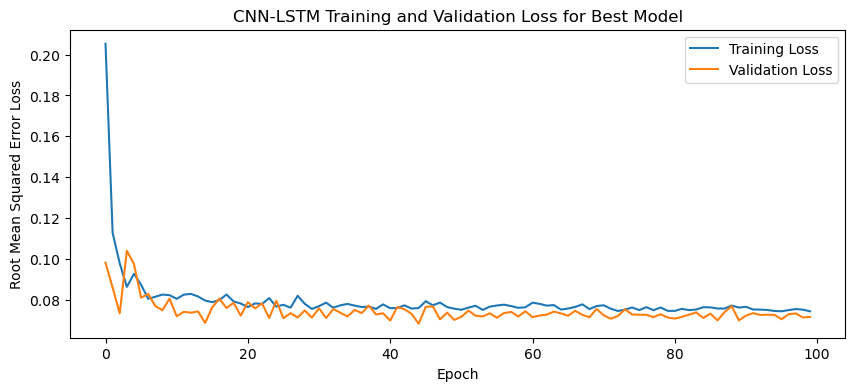

1/1 - 5s - loss: 0.0972 - 5s/epoch - 5s/step
Test Loss: 0.09715921431779861
Fold 2:
Epoch 1/100
19/19 [==============================] - 23s 328ms/step - loss: 0.2479 - val_loss: 0.1402
Epoch 2/100
19/19 [==============================] - 3s 139ms/step - loss: 0.1072 - val_loss: 0.0766
Epoch 3/100
19/19 [==============================] - 4s 210ms/step - loss: 0.0970 - val_loss: 0.0934
Epoch 4/100
19/19 [==============================] - 3s 169ms/step - loss: 0.0920 - val_loss: 0.0832
Epoch 5/100
19/19 [==============================] - 3s 146ms/step - loss: 0.0863 - val_loss: 0.0623
Epoch 6/100
19/19 [==============================] - 3s 145ms/step - loss: 0.0782 - val_loss: 0.0858
Epoch 7/100
19/19 [==============================] - 3s 187ms/step - loss: 0.0876 - val_loss: 0.0711
Epoch 8/100
19/19 [==============================] - 3s 183ms/step - loss: 0.0839 - val_loss: 0.0586
Epoch 9/100
19/19 [==============================] - 3s 156ms/step - loss: 0.0803 - val_loss: 0.0753
Epoch 

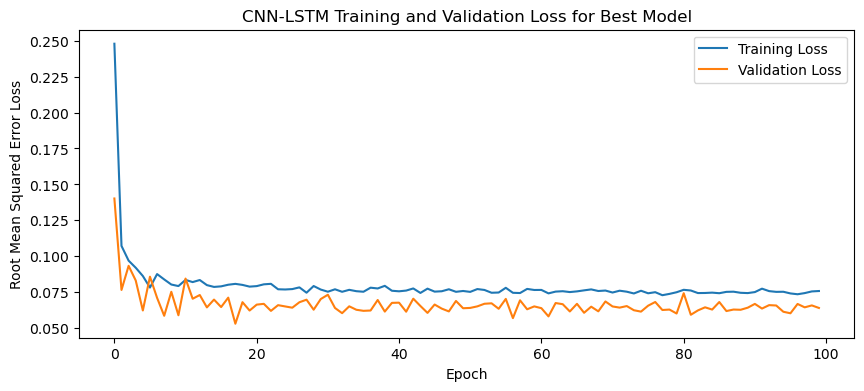

1/1 - 5s - loss: 0.0933 - 5s/epoch - 5s/step
Test Loss: 0.09325378388166428
Fold 3:
Epoch 1/100
19/19 [==============================] - 26s 422ms/step - loss: 0.2471 - val_loss: 0.1428
Epoch 2/100
19/19 [==============================] - 3s 179ms/step - loss: 0.1127 - val_loss: 0.0707
Epoch 3/100
19/19 [==============================] - 4s 227ms/step - loss: 0.1035 - val_loss: 0.0701
Epoch 4/100
19/19 [==============================] - 3s 179ms/step - loss: 0.0969 - val_loss: 0.0678
Epoch 5/100
19/19 [==============================] - 3s 162ms/step - loss: 0.0843 - val_loss: 0.0747
Epoch 6/100
19/19 [==============================] - 3s 167ms/step - loss: 0.0879 - val_loss: 0.0919
Epoch 7/100
19/19 [==============================] - 4s 204ms/step - loss: 0.0812 - val_loss: 0.0736
Epoch 8/100
19/19 [==============================] - 4s 200ms/step - loss: 0.0804 - val_loss: 0.0734
Epoch 9/100
19/19 [==============================] - 3s 177ms/step - loss: 0.0808 - val_loss: 0.0720
Epoch 

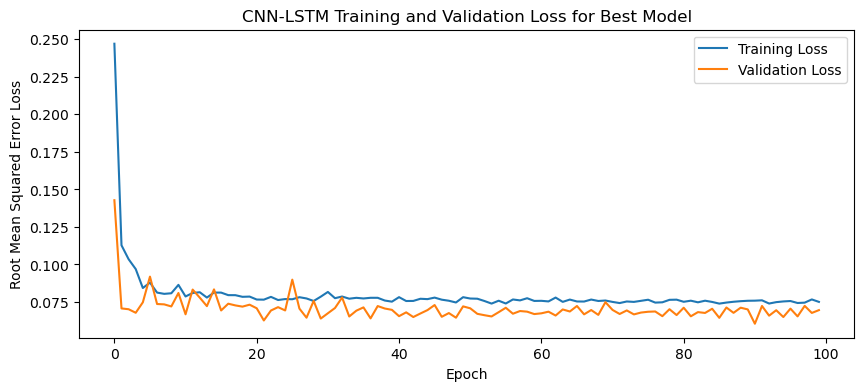

1/1 - 5s - loss: 0.0840 - 5s/epoch - 5s/step
Test Loss: 0.08404433727264404
Fold 4:
Epoch 1/100
20/20 [==============================] - 23s 397ms/step - loss: 0.3029 - val_loss: 0.1390
Epoch 2/100
20/20 [==============================] - 4s 177ms/step - loss: 0.1743 - val_loss: 0.1317
Epoch 3/100
20/20 [==============================] - 3s 150ms/step - loss: 0.1543 - val_loss: 0.1213
Epoch 4/100
20/20 [==============================] - 4s 181ms/step - loss: 0.1329 - val_loss: 0.0891
Epoch 5/100
20/20 [==============================] - 4s 177ms/step - loss: 0.1178 - val_loss: 0.1170
Epoch 6/100
20/20 [==============================] - 3s 162ms/step - loss: 0.1312 - val_loss: 0.1265
Epoch 7/100
20/20 [==============================] - 3s 143ms/step - loss: 0.1216 - val_loss: 0.0954
Epoch 8/100
20/20 [==============================] - 3s 171ms/step - loss: 0.1165 - val_loss: 0.0788
Epoch 9/100
20/20 [==============================] - 6s 279ms/step - loss: 0.1142 - val_loss: 0.0998
Epoch 

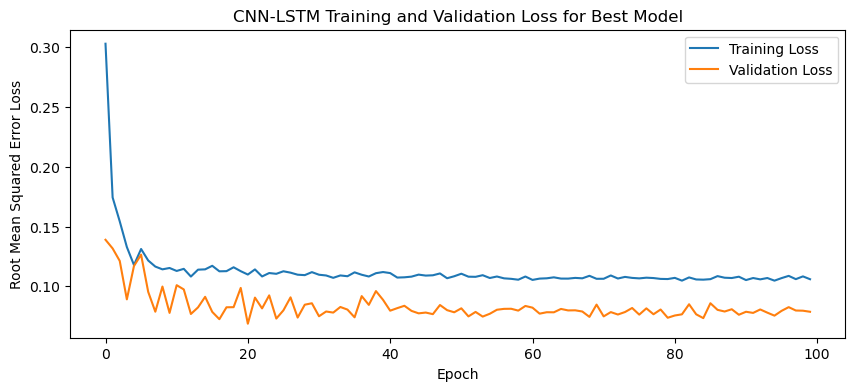

1/1 - 4s - loss: 0.1036 - 4s/epoch - 4s/step
Test Loss: 0.10364384949207306
Fold 5:
Epoch 1/100
19/19 [==============================] - 20s 452ms/step - loss: 0.2528 - val_loss: 0.1964
Epoch 2/100
19/19 [==============================] - 4s 205ms/step - loss: 0.1158 - val_loss: 0.1510
Epoch 3/100
19/19 [==============================] - 4s 209ms/step - loss: 0.1002 - val_loss: 0.1044
Epoch 4/100
19/19 [==============================] - 4s 229ms/step - loss: 0.0886 - val_loss: 0.0880
Epoch 5/100
19/19 [==============================] - 4s 216ms/step - loss: 0.0883 - val_loss: 0.0915
Epoch 6/100
19/19 [==============================] - 3s 185ms/step - loss: 0.0843 - val_loss: 0.0924
Epoch 7/100
19/19 [==============================] - 4s 200ms/step - loss: 0.0812 - val_loss: 0.0992
Epoch 8/100
19/19 [==============================] - 3s 175ms/step - loss: 0.0798 - val_loss: 0.0819
Epoch 9/100
19/19 [==============================] - 3s 165ms/step - loss: 0.0762 - val_loss: 0.1015
Epoch 

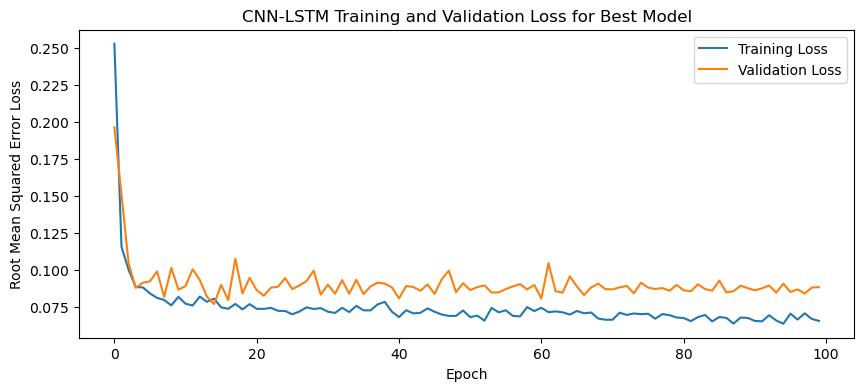

1/1 - 5s - loss: 0.0662 - 5s/epoch - 5s/step
Test Loss: 0.06621156632900238


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit a CNN-LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

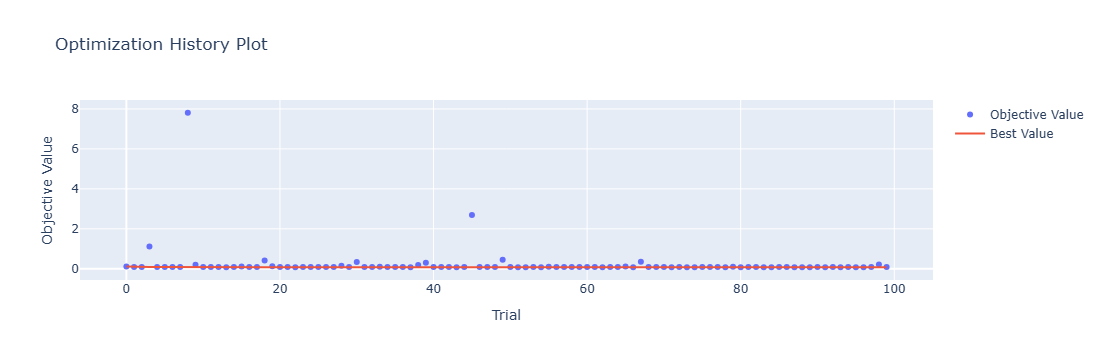

In [4]:
optuna.visualization.plot_optimization_history(study)

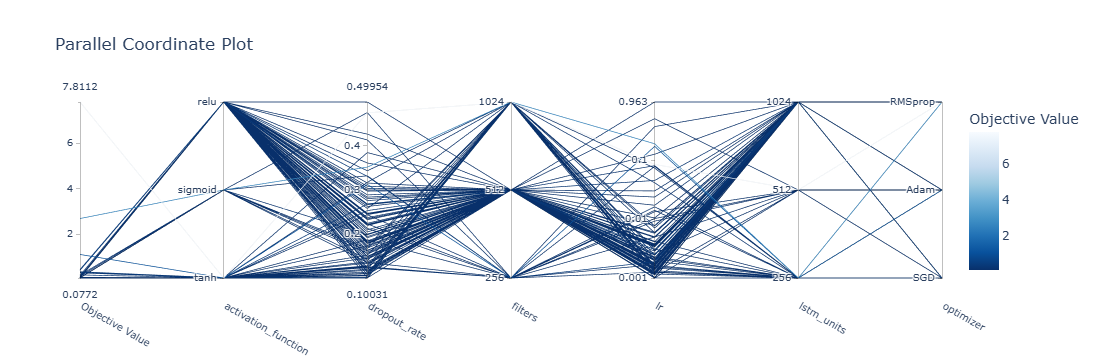

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

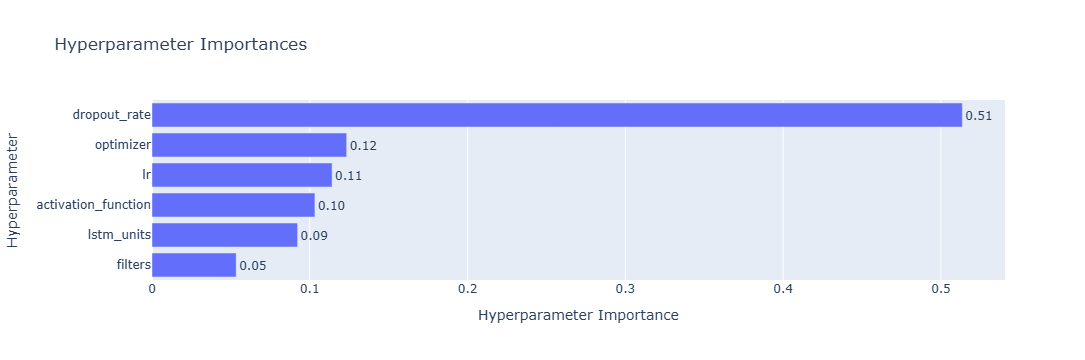

In [6]:
optuna.visualization.plot_param_importances(study)

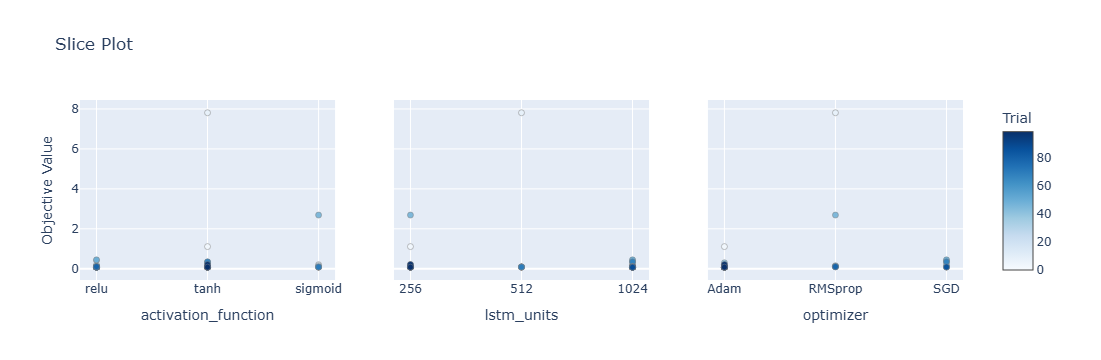

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

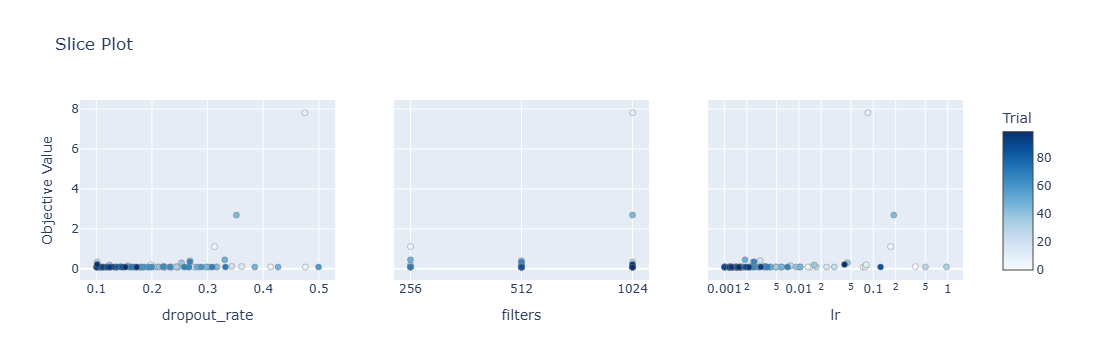

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate', 'filters'])

[[12.82 12.33 12.14 11.9  12.75 12.05 11.96 11.88 11.66 11.6  11.21 11.85
  11.29 12.12 12.23 11.95 11.91 12.96 13.05 13.43 12.59 12.54 12.66 12.47
  12.18 12.49 13.25]
 [10.07  9.17  8.73  9.1   9.64  9.62  9.38  9.31  8.9   8.65  8.67  9.09
   8.97  9.33  9.58  9.53  9.17 10.25  9.66 10.33 10.45 10.26 10.47 10.03
   9.51  9.7  10.33]]
Epoch 1/100
19/19 [==============================] - 30s 459ms/step - loss: 0.2247 - accuracy: 0.1579 - mae: 0.1899 - rmse: 0.2247 - mape: 44.3790 - pearson: 0.1945 - val_loss: 0.1250 - val_accuracy: 0.0000e+00 - val_mae: 0.0960 - val_rmse: 0.1250 - val_mape: 21.2623 - val_pearson: 0.2107
Epoch 2/100
19/19 [==============================] - 3s 155ms/step - loss: 0.1075 - accuracy: 0.2632 - mae: 0.0868 - rmse: 0.1075 - mape: 21.1724 - pearson: 0.1891 - val_loss: 0.0806 - val_accuracy: 0.3333 - val_mae: 0.0672 - val_rmse: 0.0806 - val_mape: 15.6702 - val_pearson: 0.3242
Epoch 3/100
19/19 [==============================] - 3s 137ms/step - loss: 0.0965 - ac

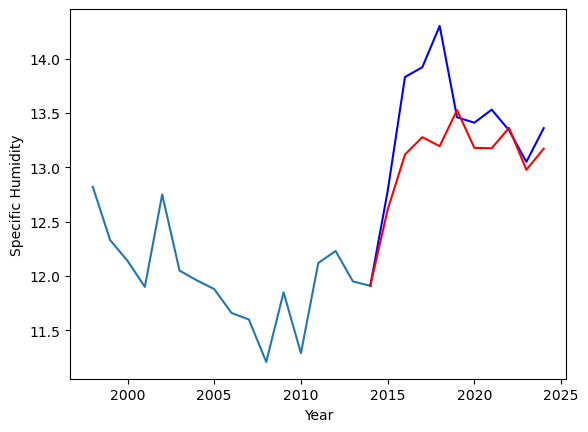

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
9.71		9.86		0.15
10.79		10.37		-0.42
10.20		10.53		0.33
10.87		10.44		-0.43
10.99		10.78		-0.21
10.80		10.43		-0.37
11.01		10.43		-0.58
10.57		10.61		0.04
10.05		10.23		0.18
10.24		10.42		0.18


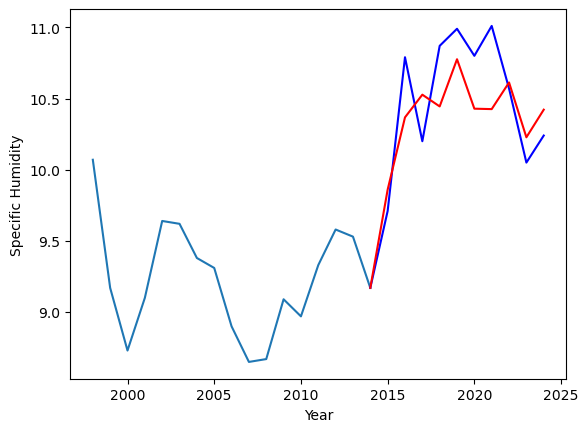

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   12.78  12.609902
1                1    9.71   9.859958


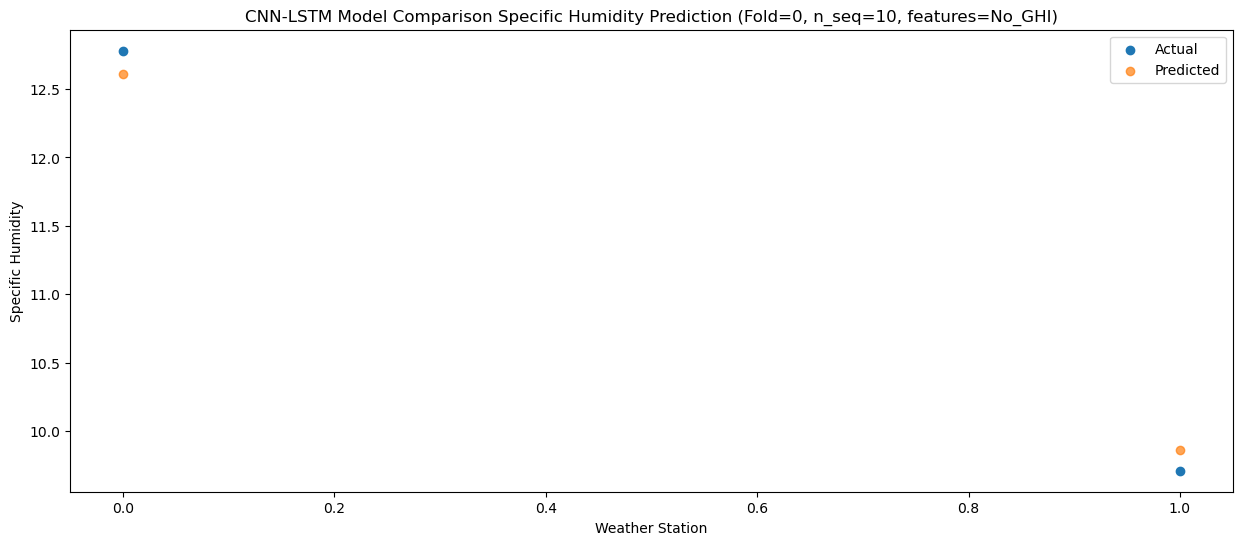

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   13.83  13.117537
1                1   10.79  10.367715


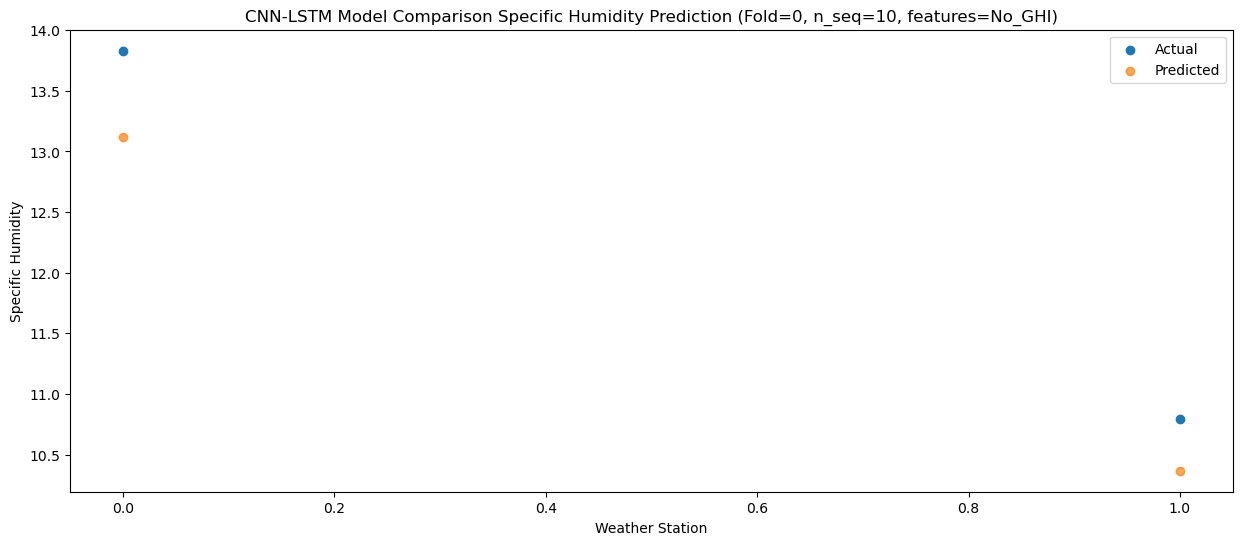

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   13.92  13.276922
1                1   10.20  10.527129


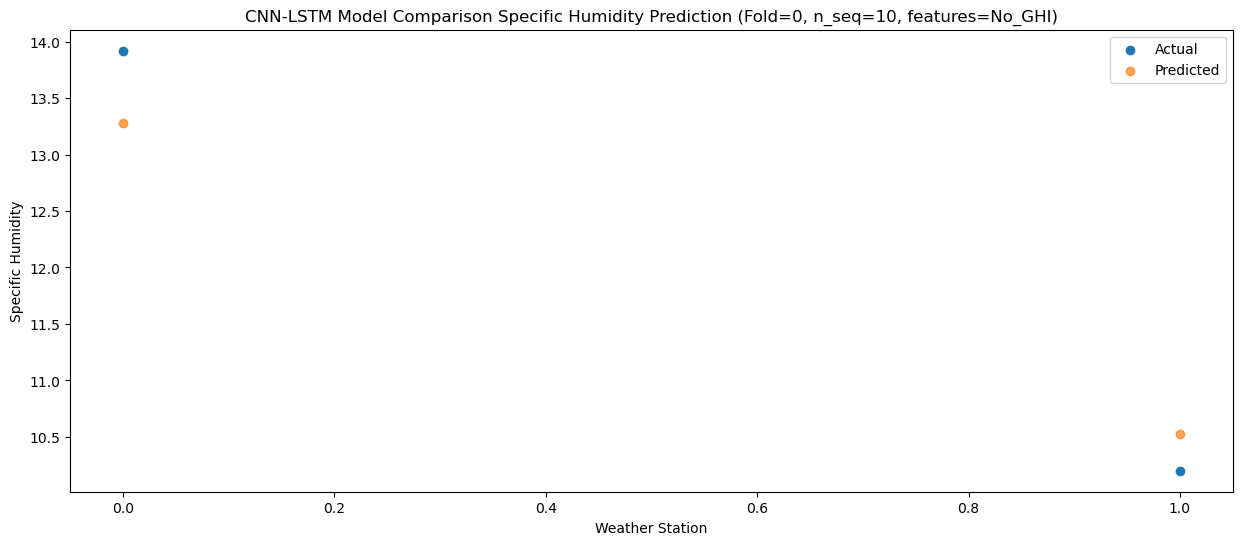

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   14.30  13.194195
1                1   10.87  10.444511


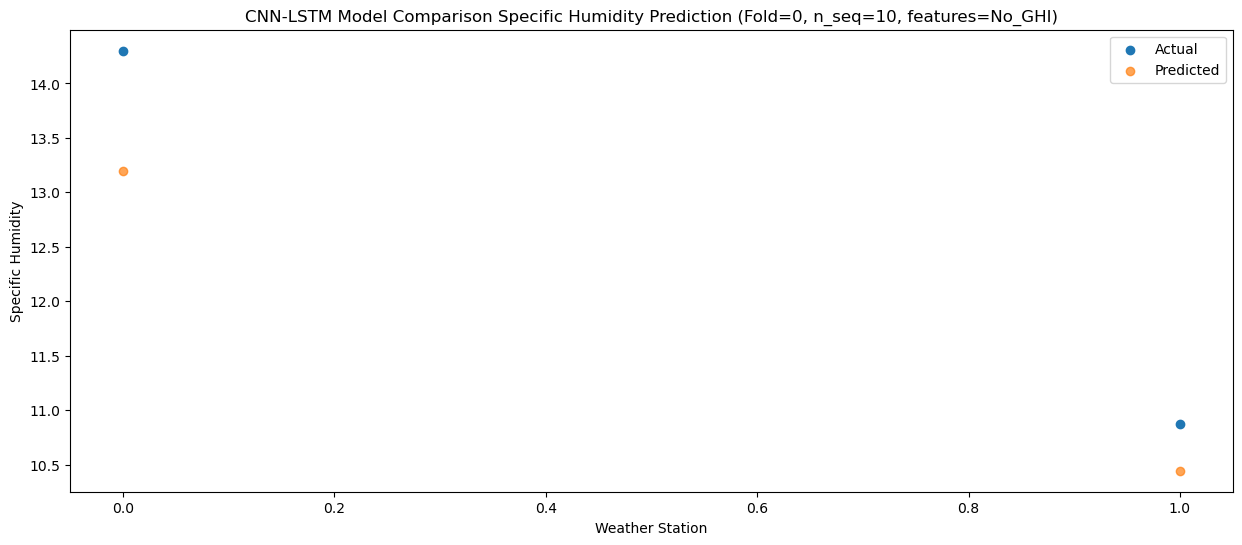

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   13.46  13.525631
1                1   10.99  10.775994


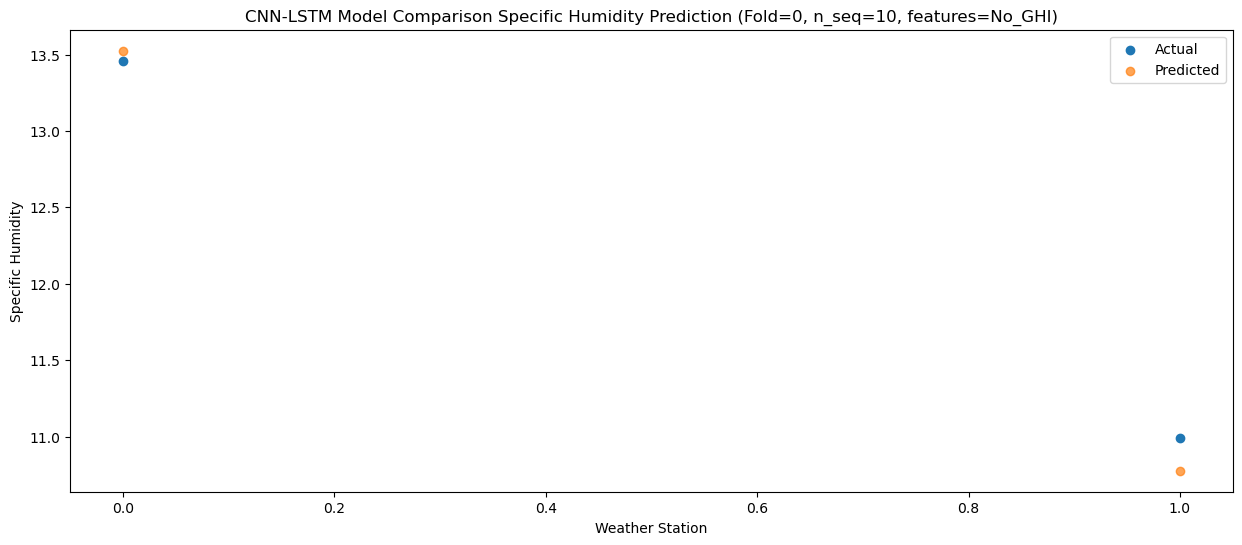

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   13.41  13.178296
1                1   10.80  10.428700


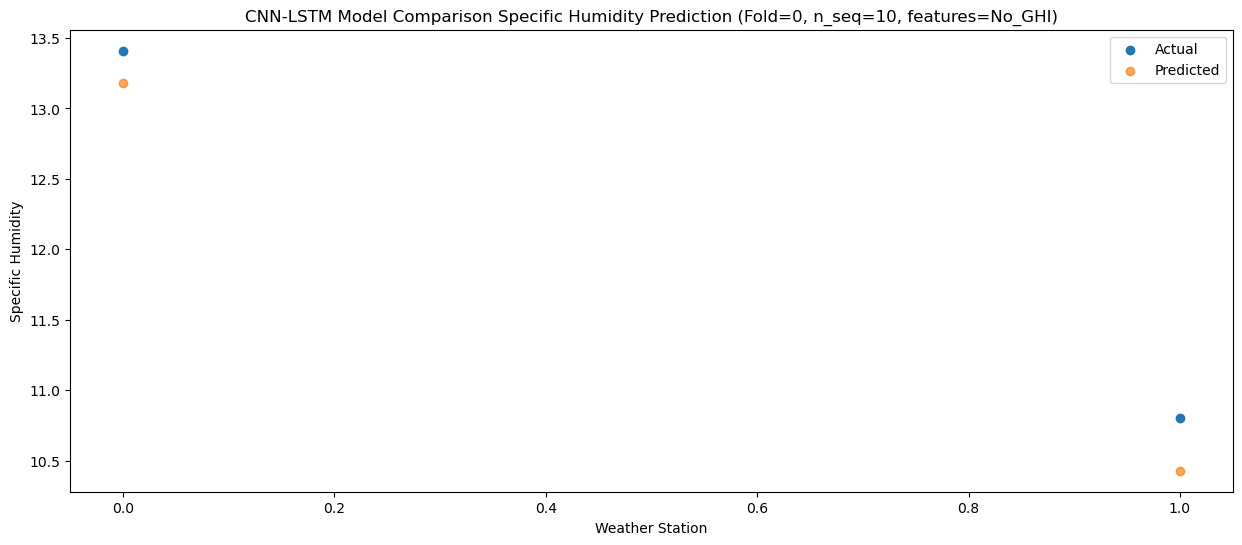

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   13.53  13.175321
1                1   11.01  10.425733


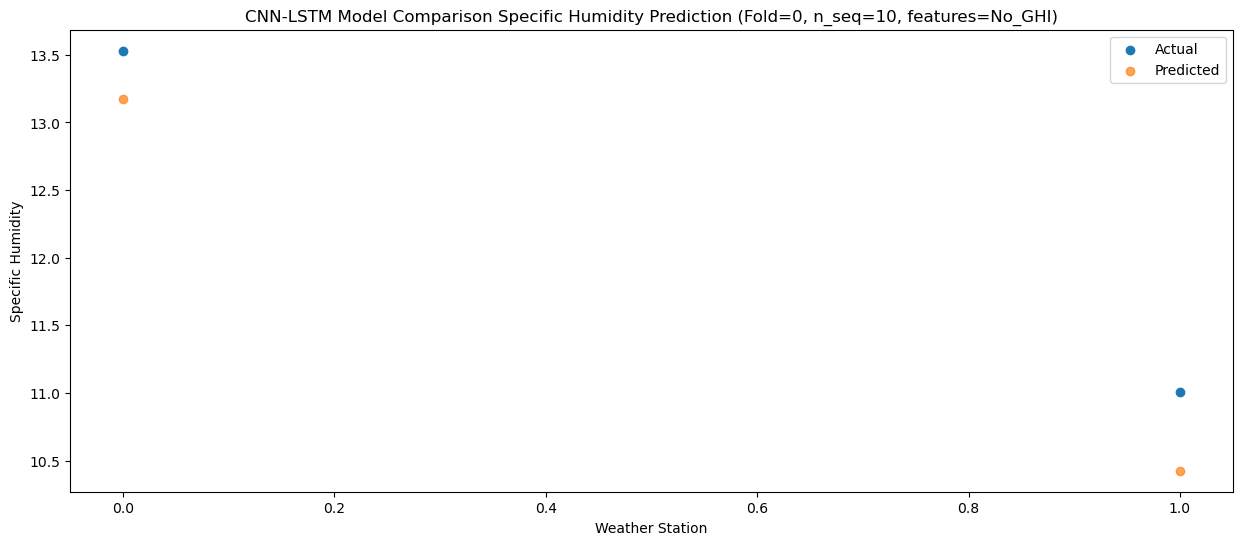

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   13.34  13.362234
1                1   10.57  10.612752


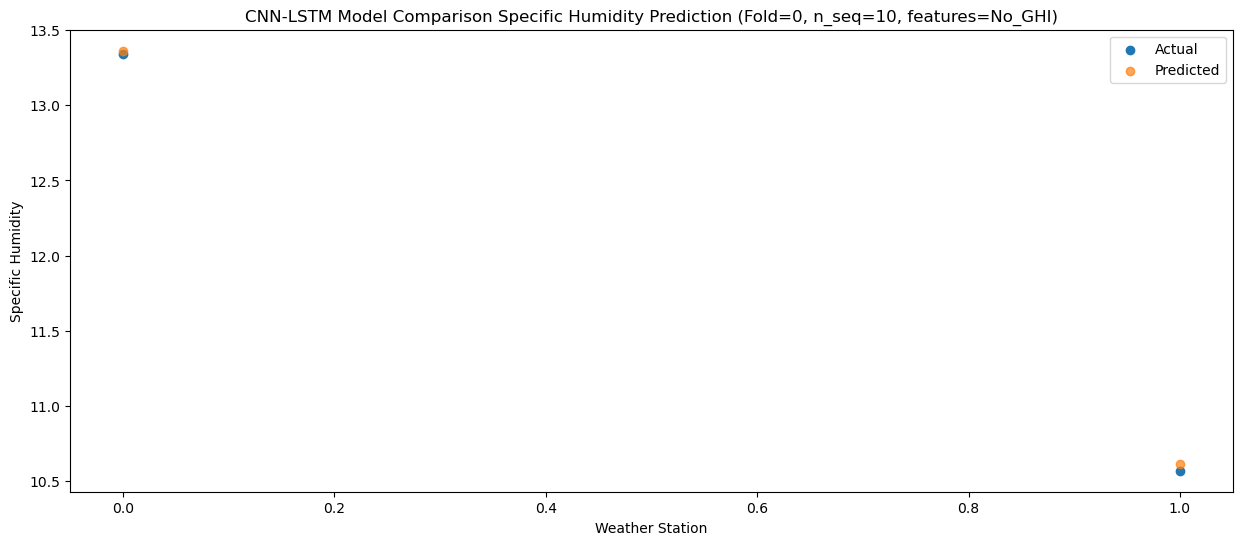

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   13.05  12.977049
1                1   10.05  10.227684


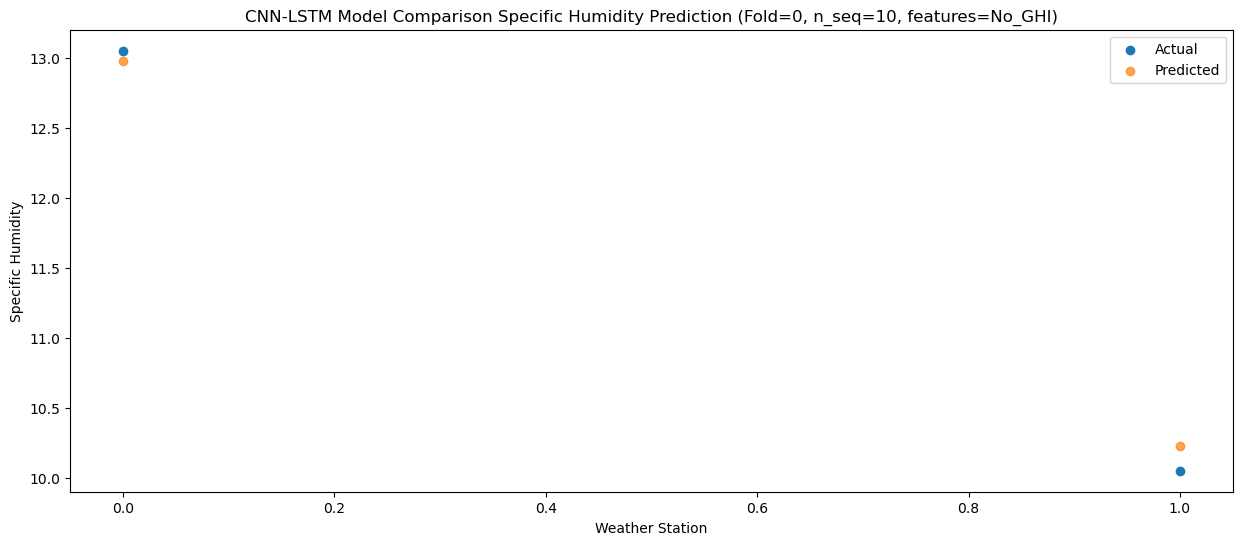

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   13.36  13.171017
1                1   10.24  10.421742


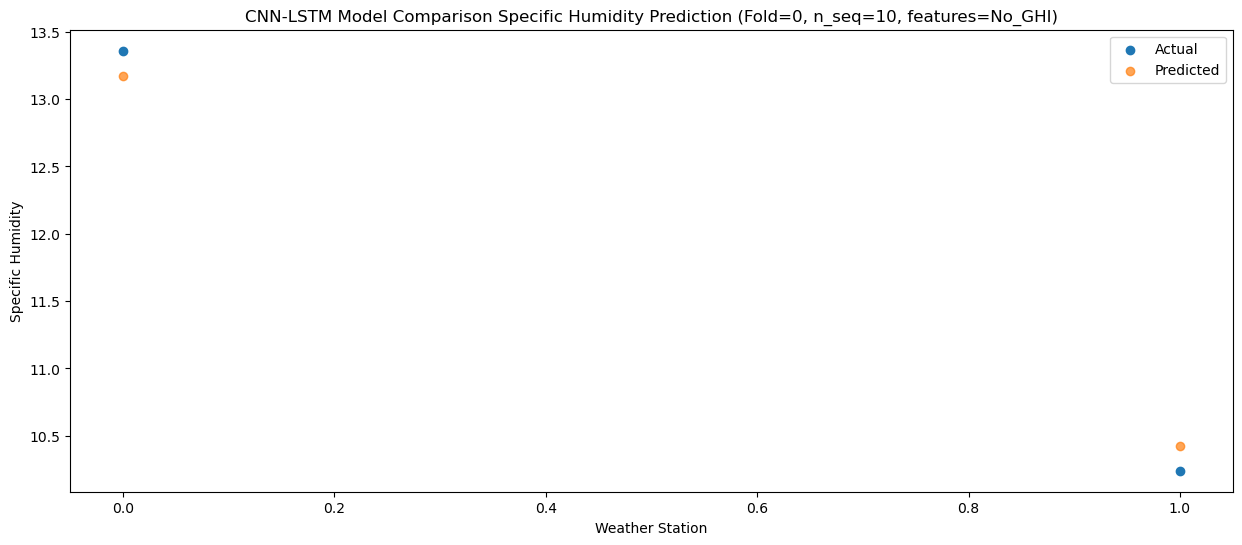

f, t:
[[12.78  9.71]
 [13.83 10.79]
 [13.92 10.2 ]
 [14.3  10.87]
 [13.46 10.99]
 [13.41 10.8 ]
 [13.53 11.01]
 [13.34 10.57]
 [13.05 10.05]
 [13.36 10.24]]
[[12.60990249  9.85995776]
 [13.11753713 10.36771549]
 [13.2769221  10.52712923]
 [13.19419543 10.44451054]
 [13.52563081 10.77599385]
 [13.17829625 10.42869955]
 [13.17532098 10.42573311]
 [13.36223425 10.61275168]
 [12.97704921 10.22768359]
 [13.17101746 10.42174231]]
Year at t+1:
t+1 SKRMSE: 0.160344
t+1 KRMSE: 0.160344
t+1 MAE: 0.160028
t+1 SKMAPE: 0.014377
t+1 R2_SCORE: 0.989088
t+1 KMAPE: 0.014377
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 11.245000
Year at t+2:
t+2 SKRMSE: 0.585631
t+2 KRMSE: 0.585631
t+2 MAE: 0.567374
t+2 SKMAPE: 0.045326
t+2 R2_SCORE: 0.851557
t+2 KMAPE: 0.045326
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 12.310000
Year at t+3:
t+3 SKRMSE: 0.510178
t+3 KRMSE: 0.510178
t+3 MAE: 0.485104
t+3 SKMAPE: 0.039135
t+3 R2_SCORE: 0.924765
t+3 KMAPE: 0.039135
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 12.060000
Year at 

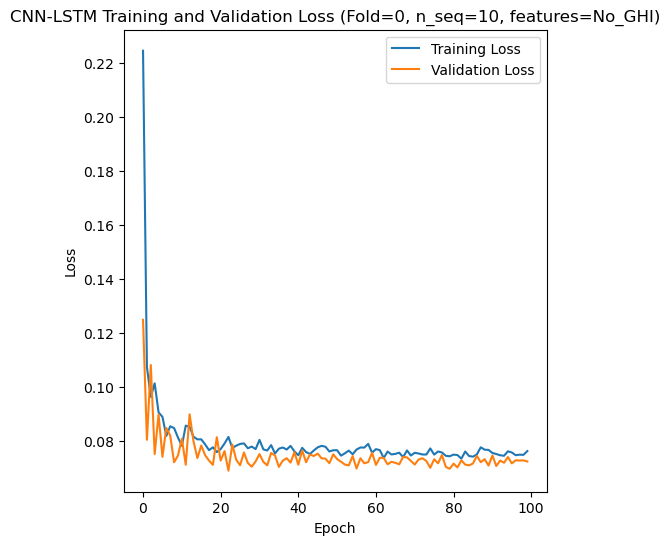

[[11.47 10.69 10.49 10.89 11.27 10.87 11.1  11.03 10.18 10.34 10.24 10.68
  10.6  10.94 10.76 10.47 10.42 11.26 10.81 11.26 11.81 11.14 11.5  10.83
  10.88 10.74 11.48]
 [ 7.63  7.36  7.16  7.53  7.72  7.87  8.49  7.73  6.89  8.03  6.62  6.93
   7.69  5.78  7.04  6.89  7.21  8.34  8.32  7.95  7.79  7.82  7.08  7.52
   6.95  7.1   7.65]]
Epoch 1/100
19/19 [==============================] - 27s 360ms/step - loss: 0.1923 - accuracy: 0.2105 - mae: 0.1654 - rmse: 0.1923 - mape: 38.1723 - pearson: 0.1606 - val_loss: 0.1309 - val_accuracy: 0.6667 - val_mae: 0.0879 - val_rmse: 0.1309 - val_mape: 18.6663 - val_pearson: 0.1973
Epoch 2/100
19/19 [==============================] - 3s 132ms/step - loss: 0.1138 - accuracy: 0.2632 - mae: 0.0902 - rmse: 0.1138 - mape: 20.9809 - pearson: 0.1923 - val_loss: 0.0733 - val_accuracy: 0.6667 - val_mae: 0.0621 - val_rmse: 0.0733 - val_mape: 14.1831 - val_pearson: 0.3987
Epoch 3/100
19/19 [==============================] - 3s 148ms/step - loss: 0.1012 - accura

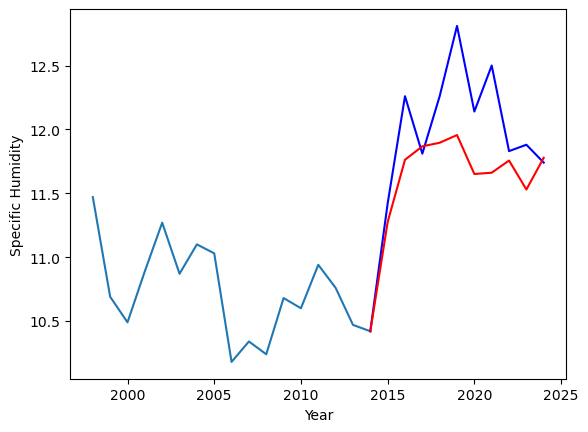

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.95		7.43		-0.52
9.08		7.92		-1.16
9.06		8.03		-1.03
8.69		8.06		-0.63
8.53		8.12		-0.41
8.56		7.81		-0.75
7.82		7.82		0.00
8.26		7.92		-0.34
7.69		7.69		-0.00
7.84		7.94		0.10


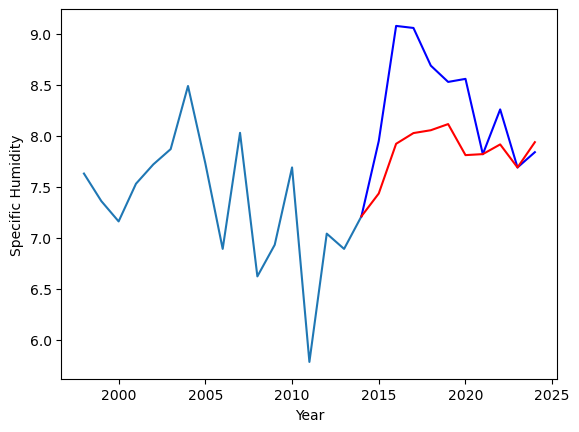

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.42  11.274481
1                1    7.95   7.434480


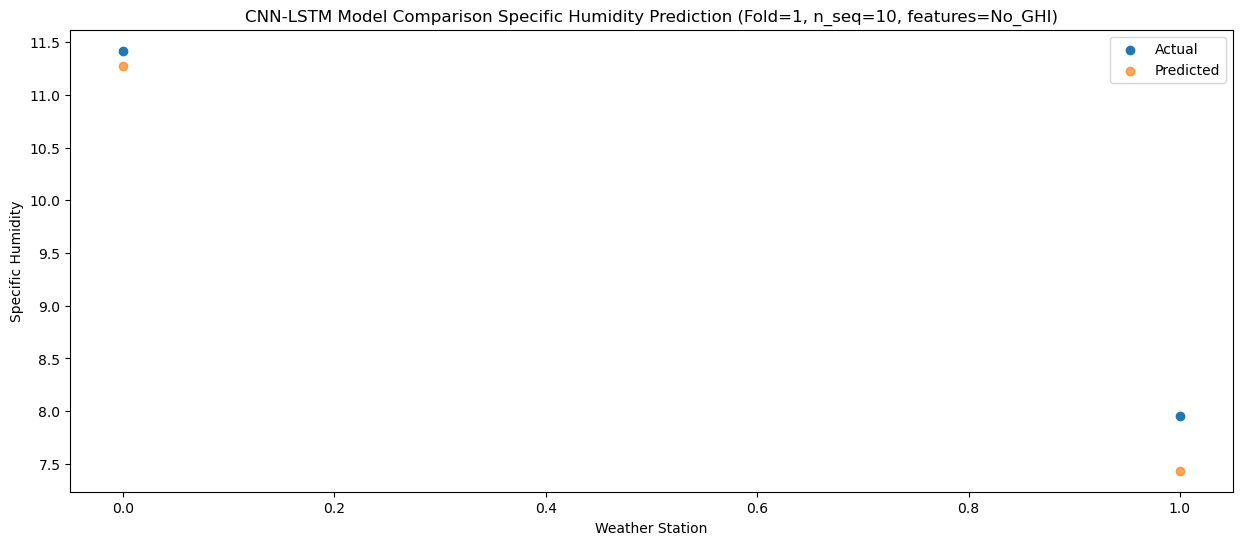

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.26  11.762416
1                1    9.08   7.922435


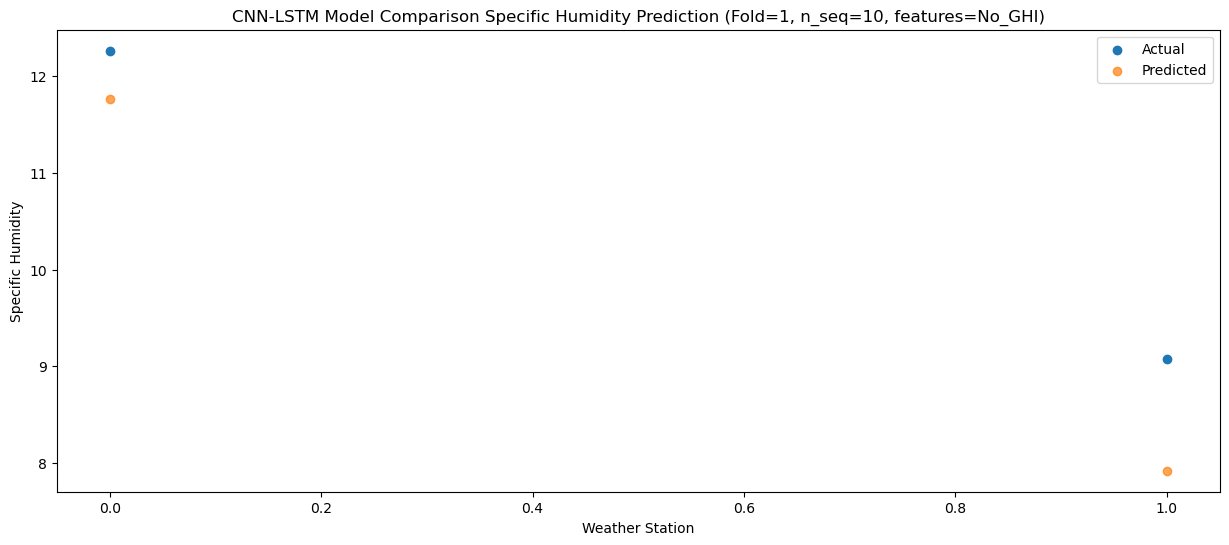

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   11.81  11.867608
1                1    9.06   8.027636


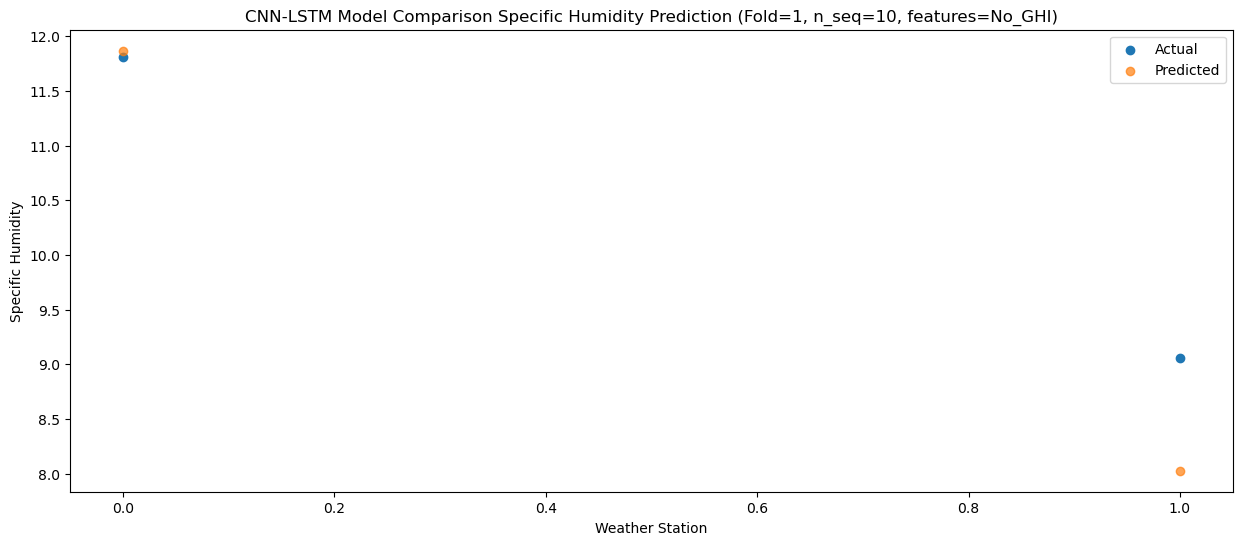

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.26  11.895534
1                1    8.69   8.055565


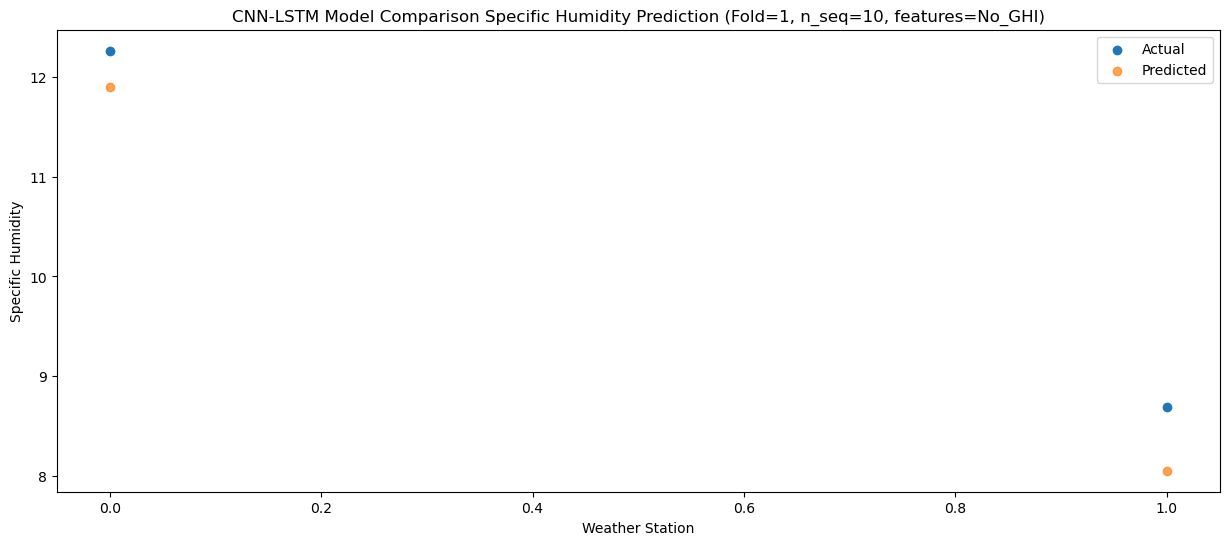

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   12.81  11.955886
1                1    8.53   8.115898


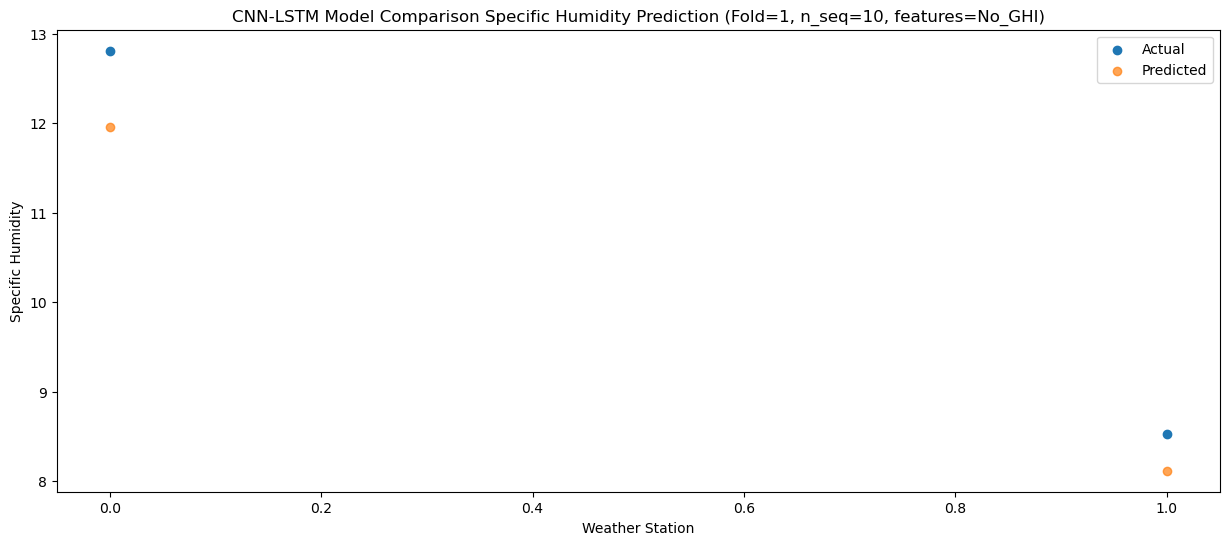

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   12.14  11.651030
1                1    8.56   7.811043


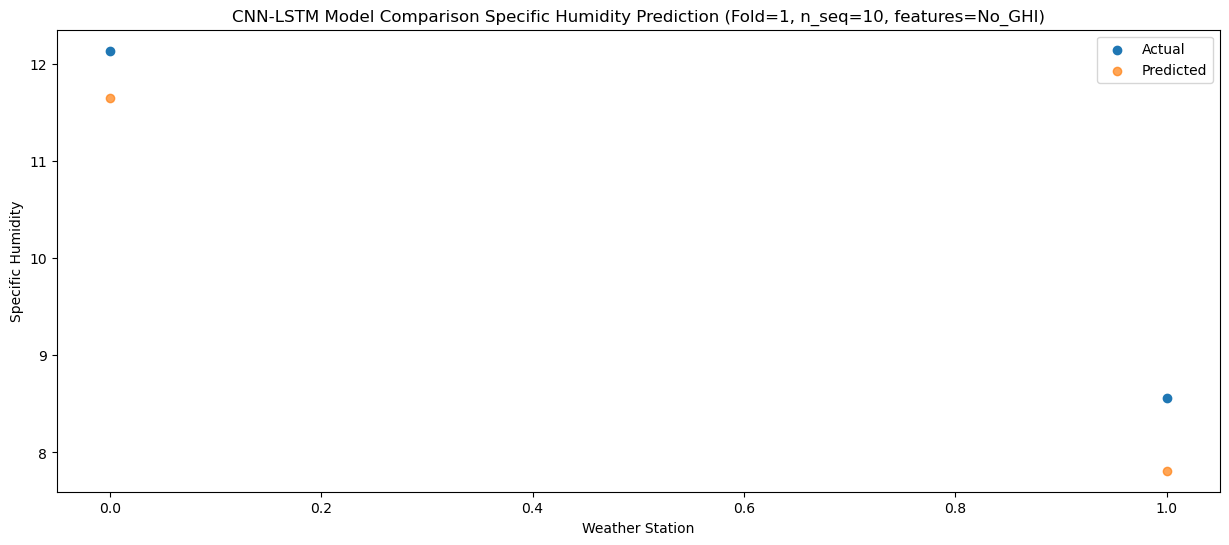

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   12.50  11.660975
1                1    7.82   7.820952


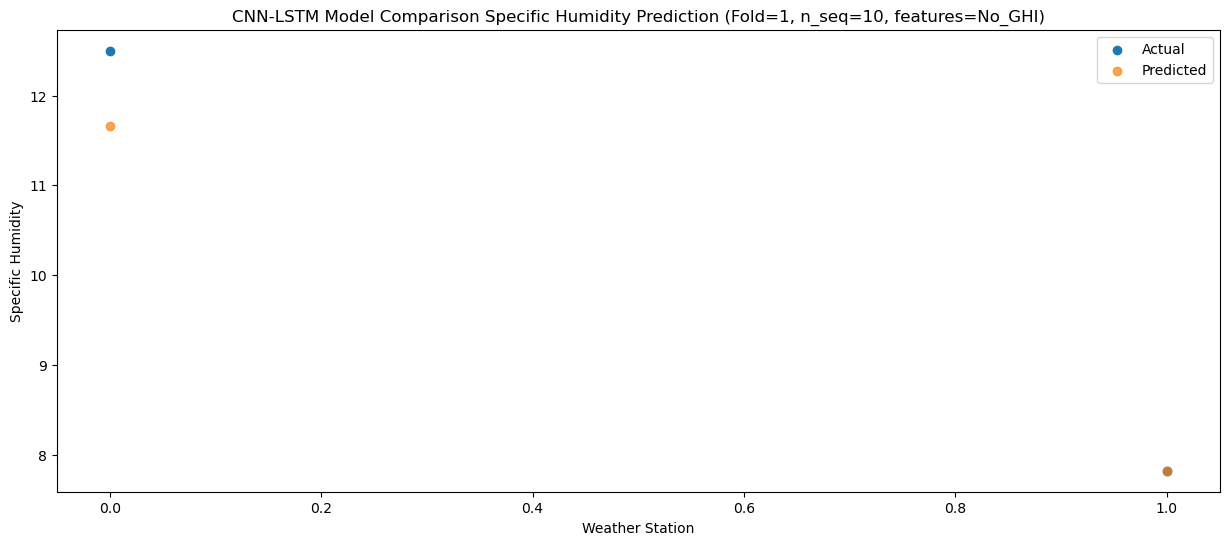

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   11.83  11.756210
1                1    8.26   7.916222


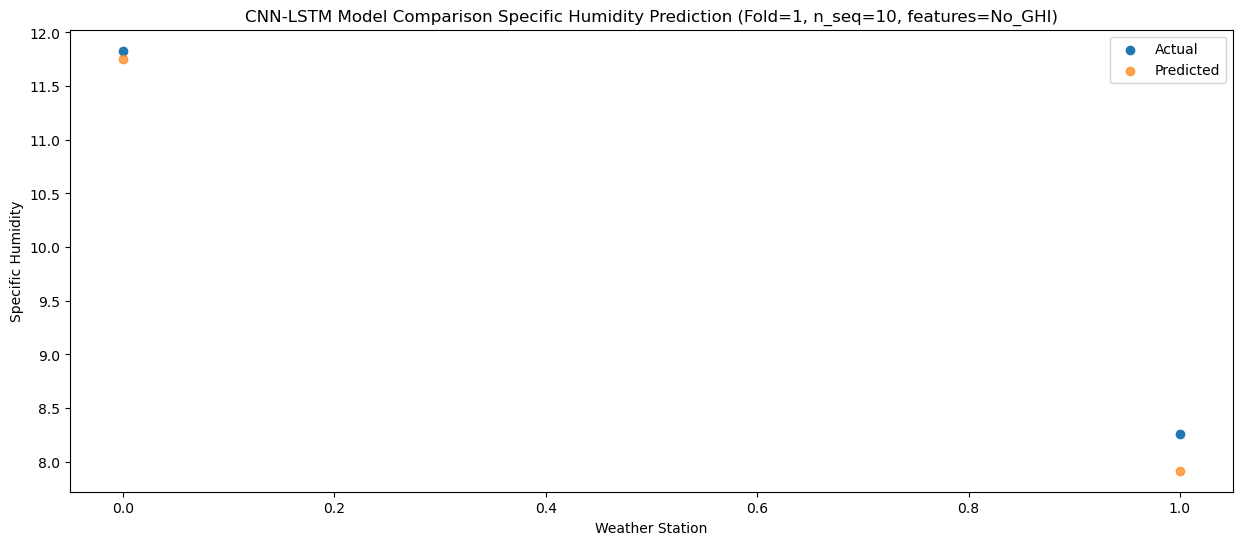

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   11.88  11.529451
1                1    7.69   7.689505


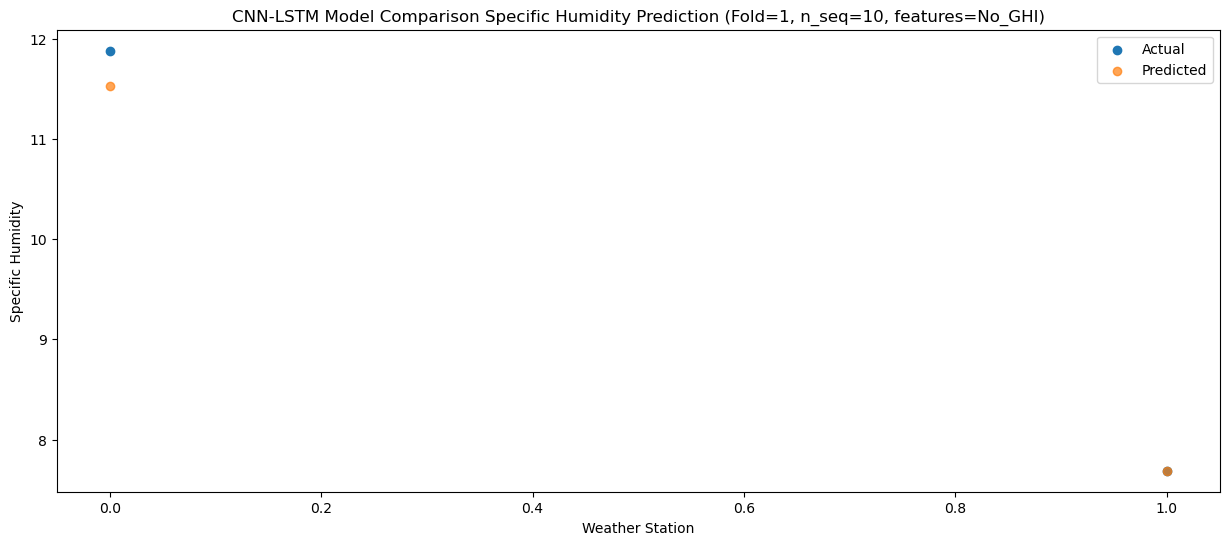

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   11.74  11.778210
1                1    7.84   7.938232


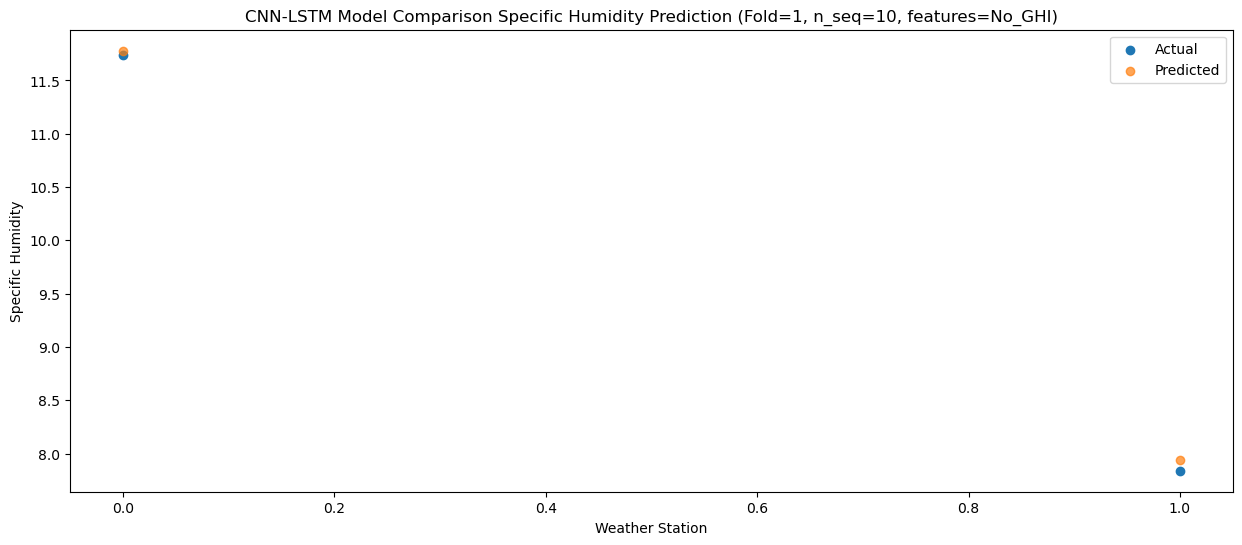

f, t:
[[11.42  7.95]
 [12.26  9.08]
 [11.81  9.06]
 [12.26  8.69]
 [12.81  8.53]
 [12.14  8.56]
 [12.5   7.82]
 [11.83  8.26]
 [11.88  7.69]
 [11.74  7.84]]
[[11.27448076  7.43448021]
 [11.76241568  7.9224348 ]
 [11.86760774  8.02763603]
 [11.89553385  8.05556541]
 [11.9558861   8.11589797]
 [11.65103025  7.81104307]
 [11.66097454  7.82095207]
 [11.75621002  7.91622202]
 [11.52945145  7.68950475]
 [11.77821029  7.93823199]]
Year at t+1:
t+1 SKRMSE: 0.378772
t+1 KRMSE: 0.378772
t+1 MAE: 0.330520
t+1 SKMAPE: 0.038794
t+1 R2_SCORE: 0.952340
t+1 KMAPE: 0.038794
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.685000
Year at t+2:
t+2 SKRMSE: 0.890940
t+2 KRMSE: 0.890940
t+2 MAE: 0.827575
t+2 SKMAPE: 0.084036
t+2 R2_SCORE: 0.686020
t+2 KMAPE: 0.084036
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 10.670000
Year at t+3:
t+3 SKRMSE: 0.731127
t+3 KRMSE: 0.731127
t+3 MAE: 0.544986
t+3 SKMAPE: 0.059413
t+3 R2_SCORE: 0.717264
t+3 KMAPE: 0.059413
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 10.435000
Year at t

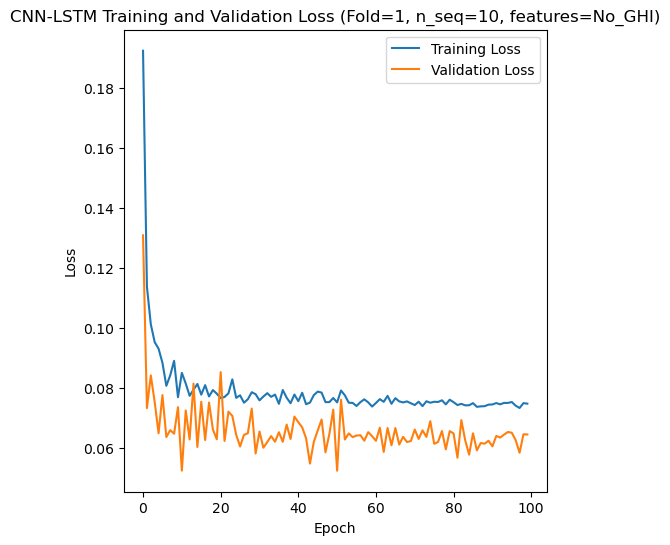

[[ 9.91  9.14  8.93  8.85  8.98  9.08  8.94  8.84  8.35  8.13  8.01  8.88
   8.79  8.86  9.22  8.7   8.51  9.48  9.05  9.73 10.13  9.86  9.33  8.92
   8.82  9.09  9.65]
 [ 8.49  7.33  7.71  7.76  7.77  7.75  7.45  7.41  7.43  7.25  7.05  7.35
   7.52  7.92  7.47  7.81  7.    7.75  8.3   8.25  8.35  7.7   7.52  7.59
   7.86  7.87  8.55]]
Epoch 1/100
19/19 [==============================] - 31s 401ms/step - loss: 0.2592 - accuracy: 0.2105 - mae: 0.2313 - rmse: 0.2592 - mape: 52.3280 - pearson: 0.1397 - val_loss: 0.1309 - val_accuracy: 0.3333 - val_mae: 0.1114 - val_rmse: 0.1309 - val_mape: 26.6339 - val_pearson: 0.0652
Epoch 2/100
19/19 [==============================] - 2s 131ms/step - loss: 0.1212 - accuracy: 0.3158 - mae: 0.0994 - rmse: 0.1212 - mape: 23.0695 - pearson: 0.2029 - val_loss: 0.1135 - val_accuracy: 0.0000e+00 - val_mae: 0.0930 - val_rmse: 0.1135 - val_mape: 19.8254 - val_pearson: 0.3847
Epoch 3/100
19/19 [==============================] - 2s 123ms/step - loss: 0.1033 - ac

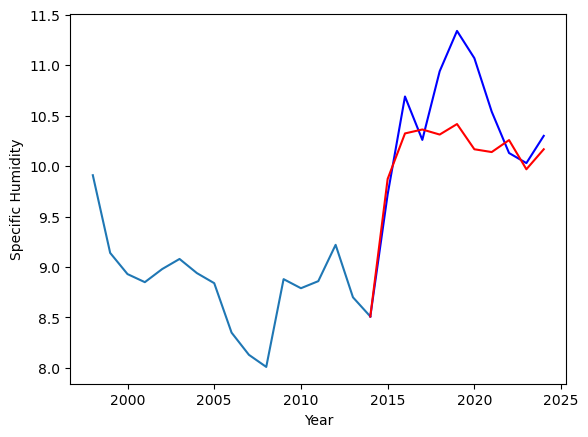

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.68		8.45		0.77
8.43		8.90		0.47
8.98		8.94		-0.04
8.93		8.89		-0.04
9.03		9.00		-0.03
8.38		8.75		0.37
8.20		8.72		0.52
8.27		8.84		0.57
8.54		8.55		0.01
8.55		8.75		0.20


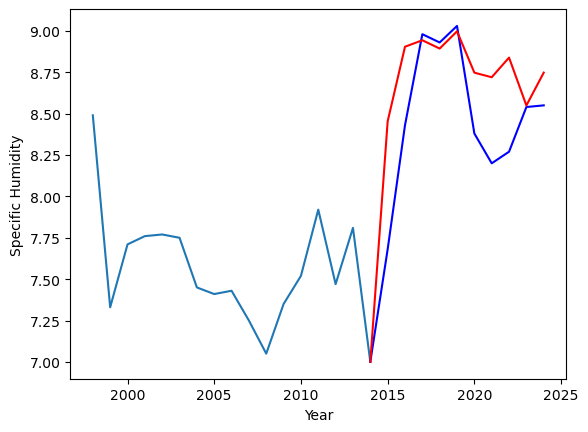

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    9.72   9.872887
1                1    7.68   8.452968


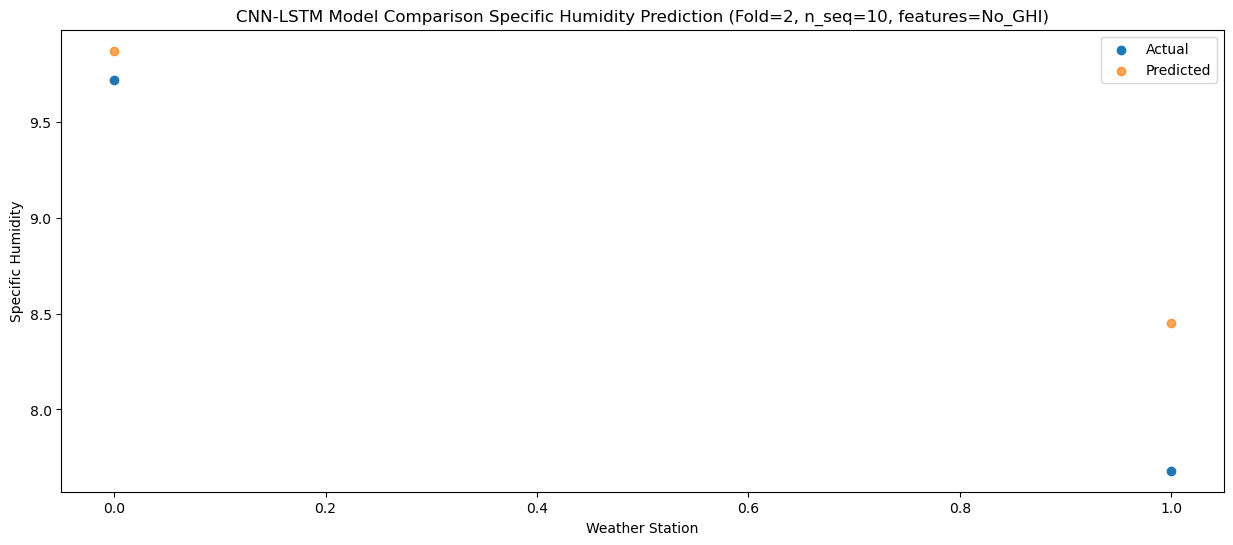

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   10.69  10.324102
1                1    8.43   8.904270


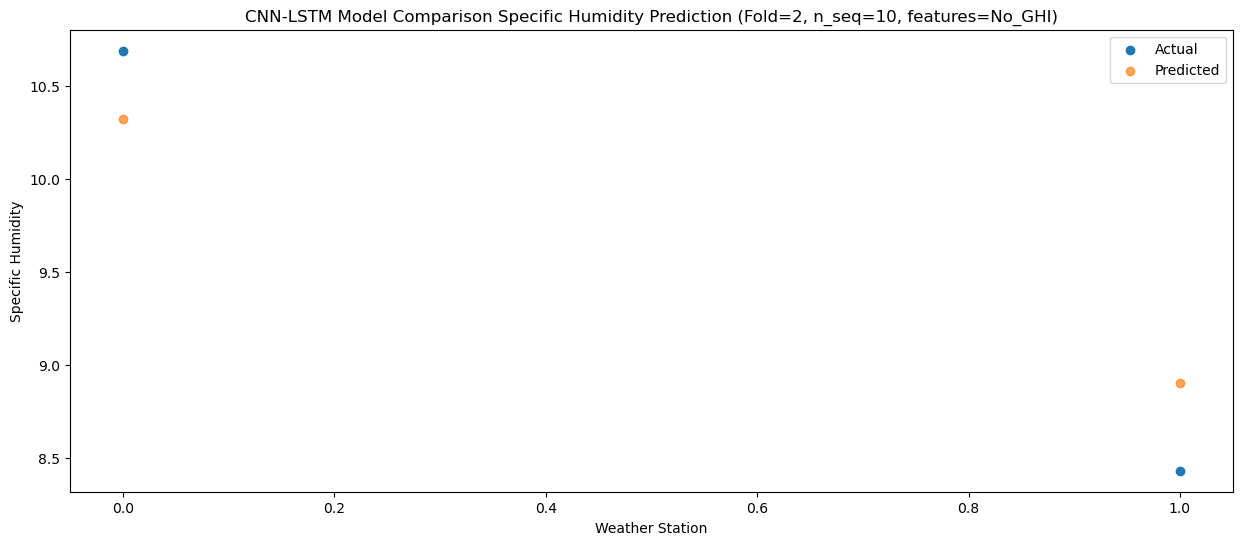

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   10.26  10.363173
1                1    8.98   8.943402


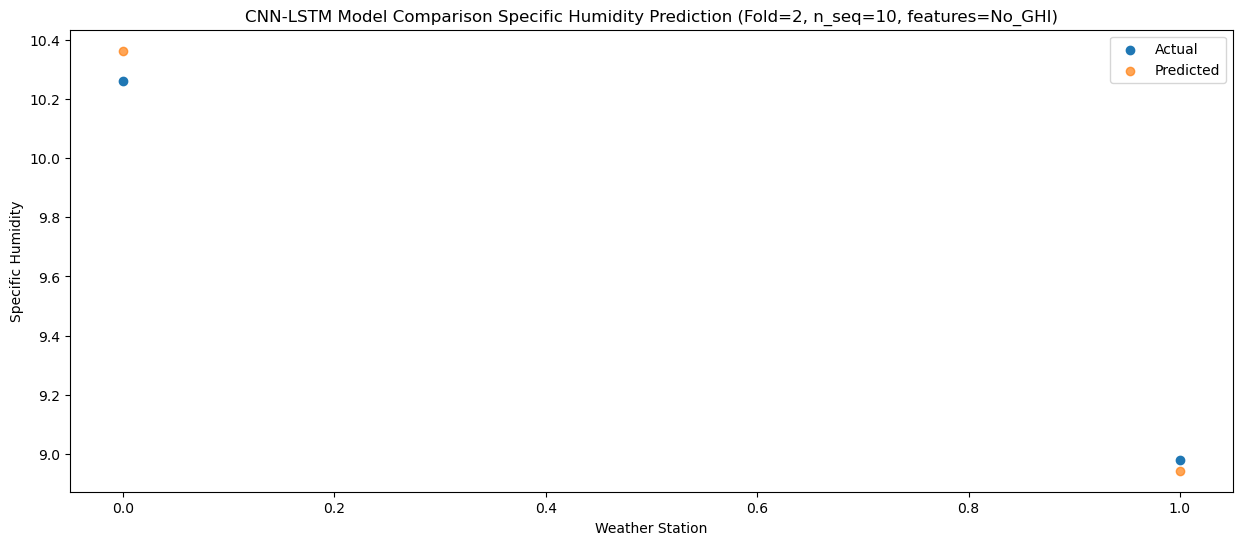

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.94  10.312923
1                1    8.93   8.893208


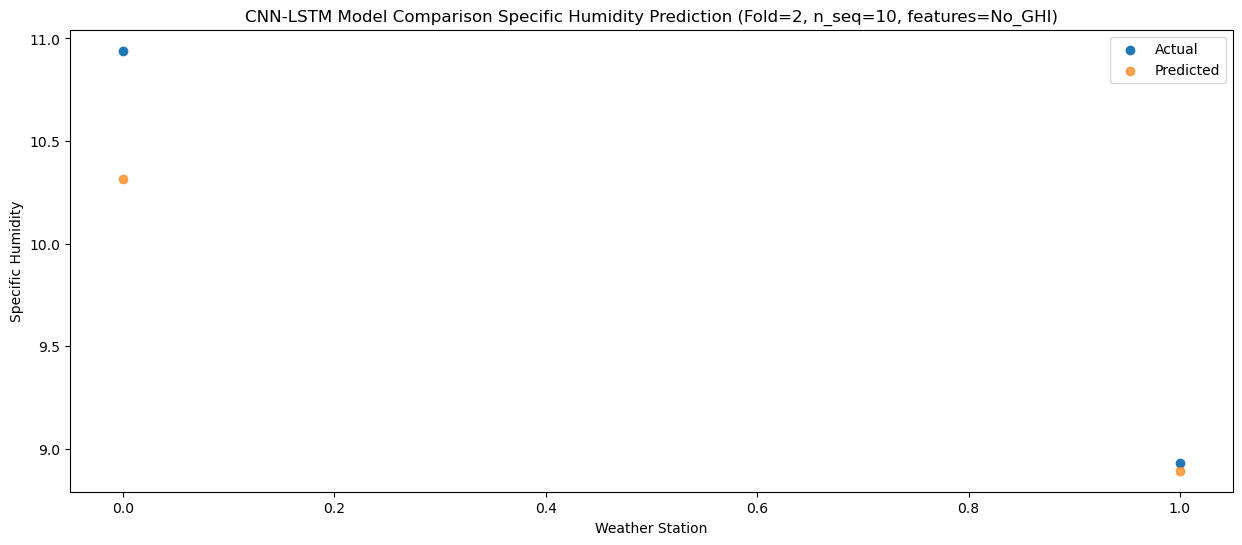

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.34  10.417033
1                1    9.03   8.997399


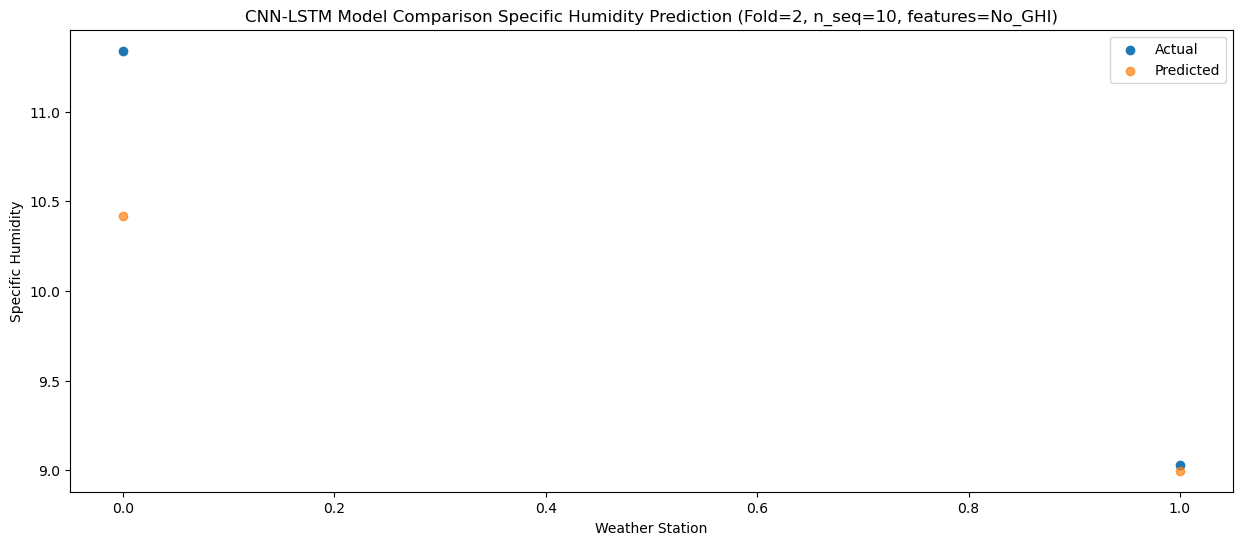

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   11.07  10.167184
1                1    8.38   8.747605


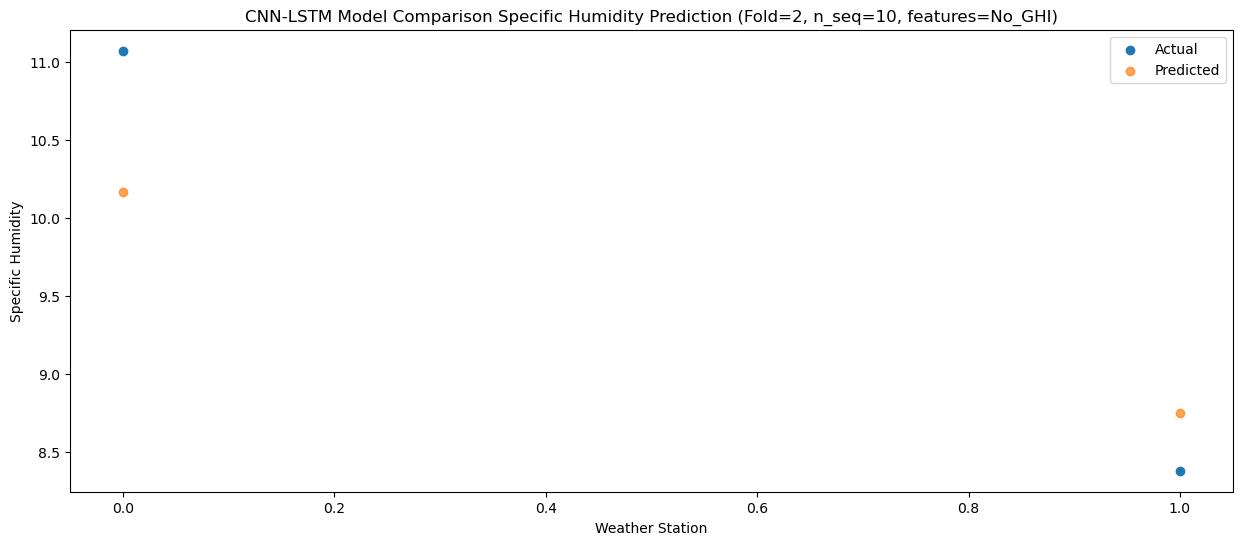

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   10.54  10.139452
1                1    8.20   8.719953


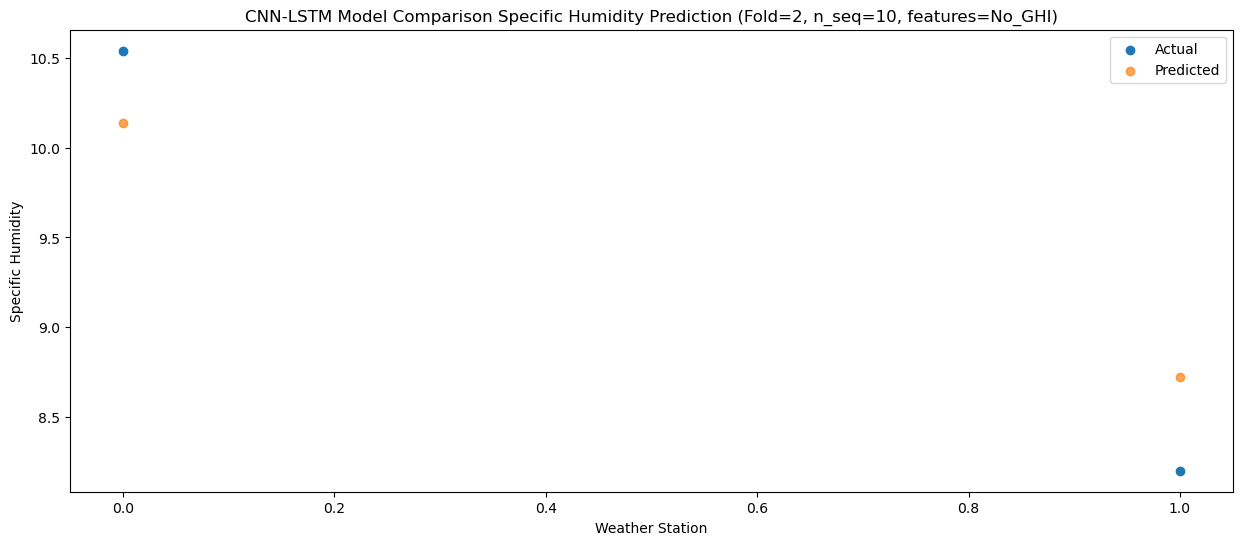

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   10.13  10.258105
1                1    8.27   8.838648


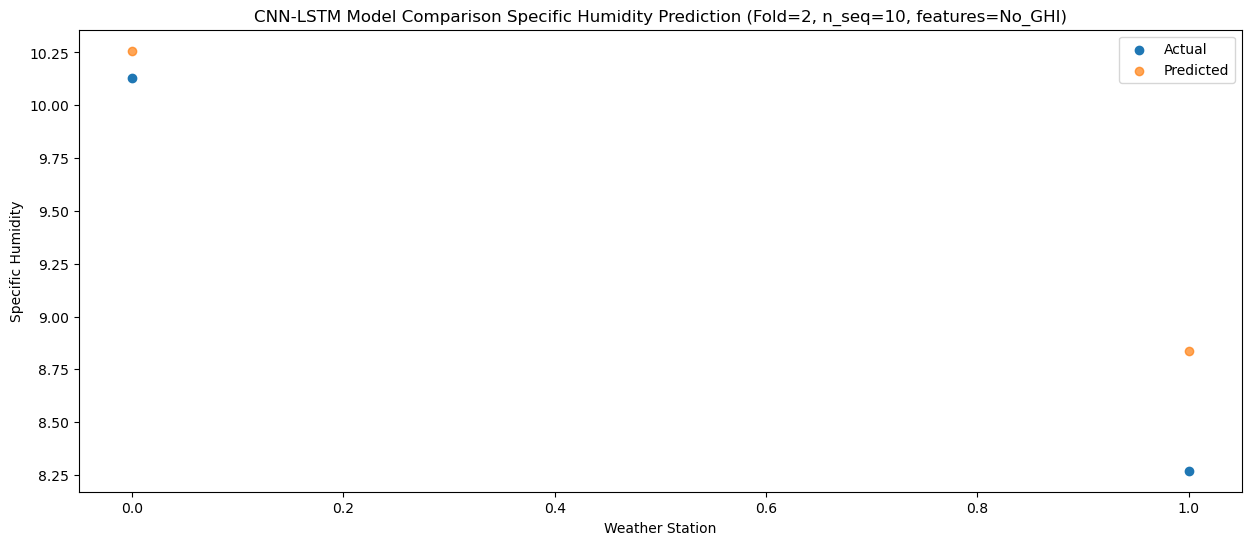

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   10.03   9.968808
1                1    8.54   8.549405


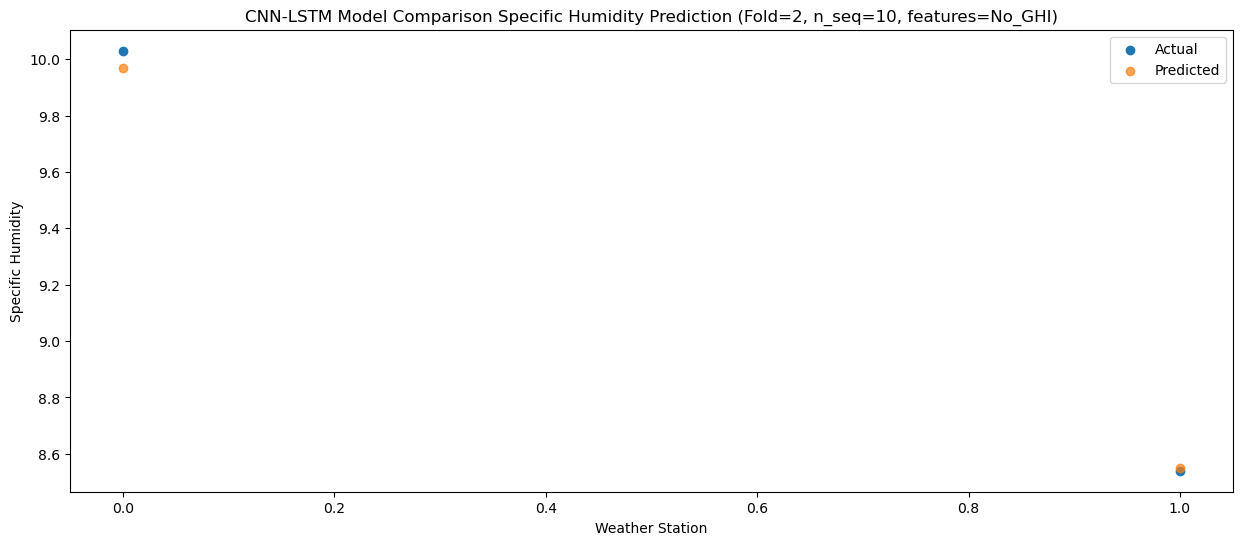

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   10.30  10.167142
1                1    8.55   8.747820


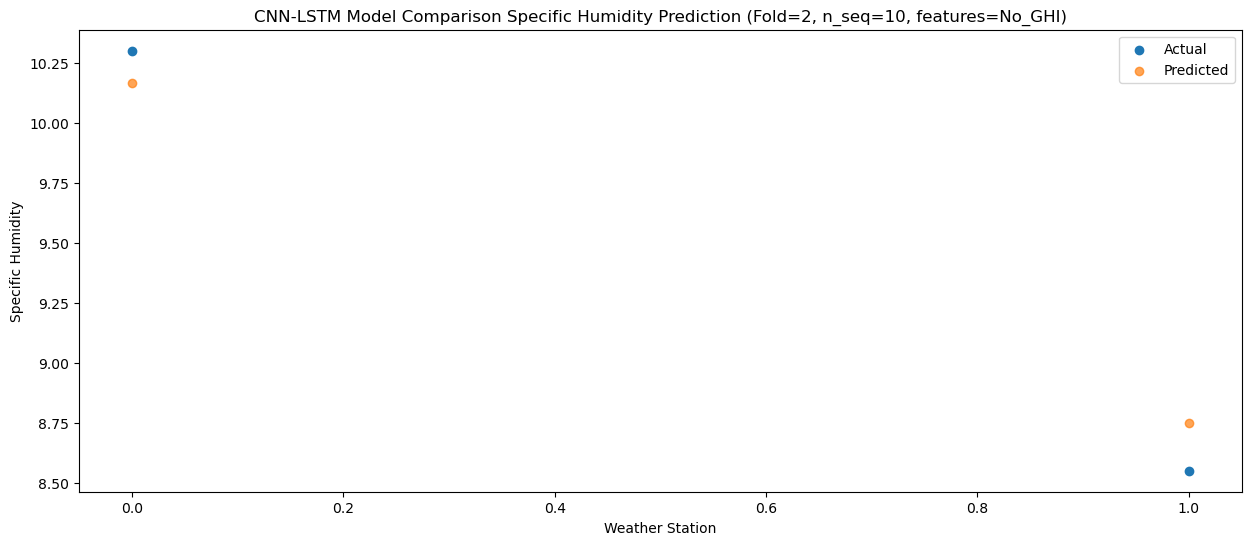

f, t:
[[ 9.72  7.68]
 [10.69  8.43]
 [10.26  8.98]
 [10.94  8.93]
 [11.34  9.03]
 [11.07  8.38]
 [10.54  8.2 ]
 [10.13  8.27]
 [10.03  8.54]
 [10.3   8.55]]
[[ 9.87288748  8.45296819]
 [10.32410177  8.90427004]
 [10.36317278  8.94340219]
 [10.31292269  8.89320819]
 [10.41703328  8.99739907]
 [10.16718382  8.74760544]
 [10.13945159  8.71995337]
 [10.25810502  8.83864824]
 [ 9.96880809  8.54940481]
 [10.16714159  8.74781998]]
Year at t+1:
t+1 SKRMSE: 0.557160
t+1 KRMSE: 0.557160
t+1 MAE: 0.462928
t+1 SKMAPE: 0.058188
t+1 R2_SCORE: 0.701627
t+1 KMAPE: 0.058188
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 8.700000
Year at t+2:
t+2 SKRMSE: 0.423564
t+2 KRMSE: 0.423564
t+2 MAE: 0.420084
t+2 SKMAPE: 0.045244
t+2 R2_SCORE: 0.859498
t+2 KMAPE: 0.045244
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.560000
Year at t+3:
t+3 SKRMSE: 0.077408
t+3 KRMSE: 0.077408
t+3 MAE: 0.069885
t+3 SKMAPE: 0.007066
t+3 R2_SCORE: 0.985371
t+3 KMAPE: 0.007066
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 9.620000
Year at t+4

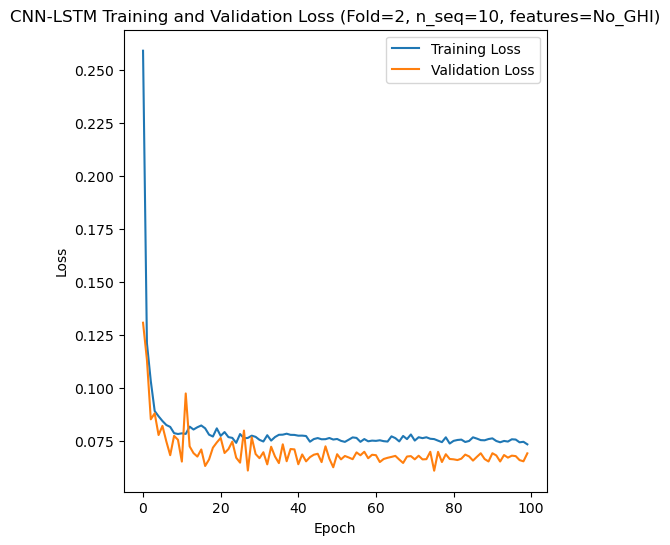

[[4.45 7.03 7.66 7.5  7.   7.5  6.8  7.19 6.85 6.32 6.46 6.61 7.06 6.53
  6.68 6.3  6.77 6.95 6.79 7.44 7.02 7.12 7.47 7.01 6.62 7.19 7.31]
 [8.33 7.39 7.85 8.23 8.15 7.91 8.01 7.7  7.52 7.54 7.12 7.57 7.71 8.23
  7.93 7.83 7.45 8.09 8.19 8.01 8.37 8.25 8.16 8.13 7.66 7.68 8.3 ]]
Epoch 1/100
20/20 [==============================] - 23s 374ms/step - loss: 0.3140 - accuracy: 0.3000 - mae: 0.2791 - rmse: 0.3140 - mape: 47.3546 - pearson: 0.1042 - val_loss: 0.1722 - val_accuracy: 0.0000e+00 - val_mae: 0.1472 - val_rmse: 0.1722 - val_mape: 25.6310 - val_pearson: 0.1135
Epoch 2/100
20/20 [==============================] - 2s 102ms/step - loss: 0.1640 - accuracy: 0.3500 - mae: 0.1354 - rmse: 0.1640 - mape: 23.0441 - pearson: 0.2129 - val_loss: 0.1128 - val_accuracy: 0.5000 - val_mae: 0.0915 - val_rmse: 0.1128 - val_mape: 15.7541 - val_pearson: 0.3279
Epoch 3/100
20/20 [==============================] - 2s 107ms/step - loss: 0.1374 - accuracy: 0.4000 - mae: 0.1150 - rmse: 0.1374 - mape: 19.825

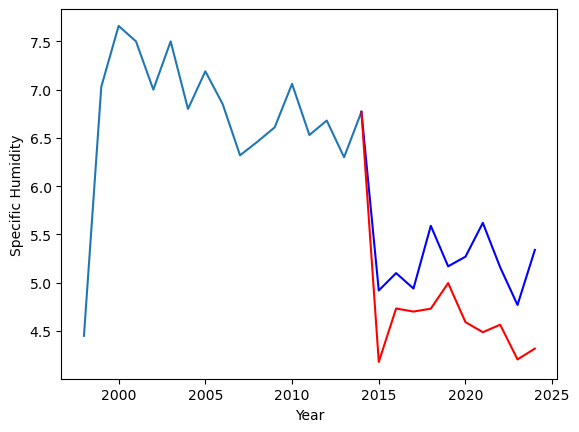

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.95		8.06		0.11
8.59		8.61		0.02
8.69		8.58		-0.11
8.51		8.61		0.10
8.87		8.88		0.01
8.75		8.47		-0.28
8.66		8.37		-0.29
8.63		8.45		-0.18
8.16		8.09		-0.07
8.18		8.20		0.02


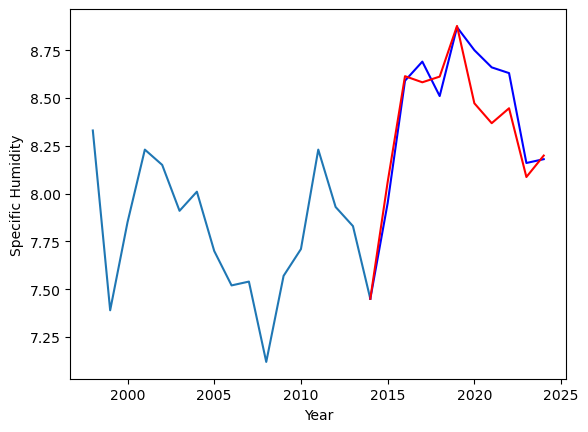

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    4.92   4.180008
1                1    7.95   8.060115


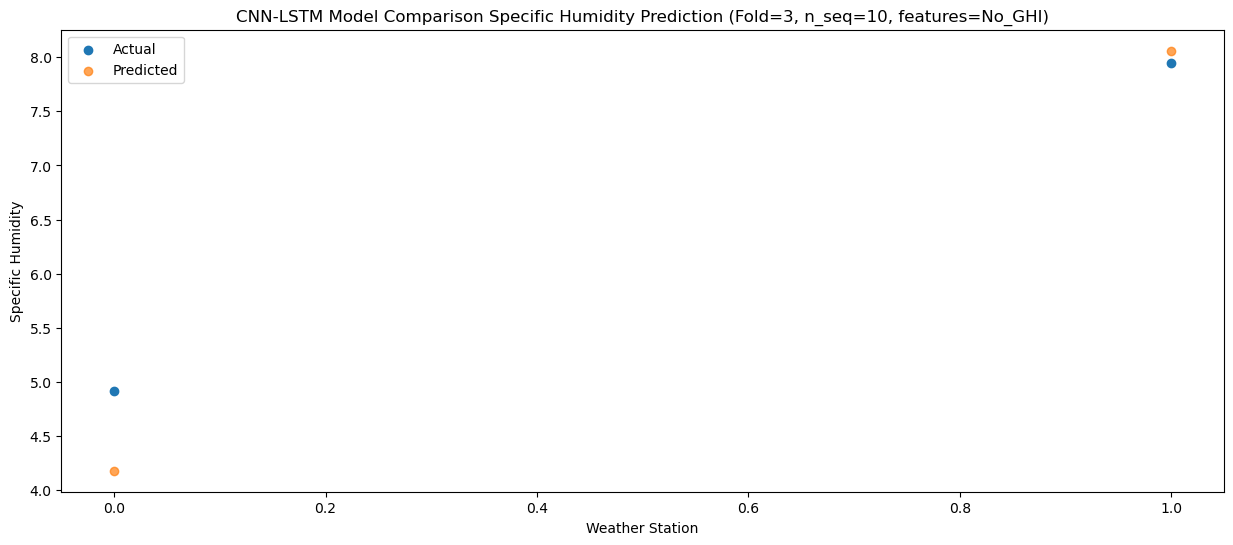

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    5.10   4.733515
1                1    8.59   8.613908


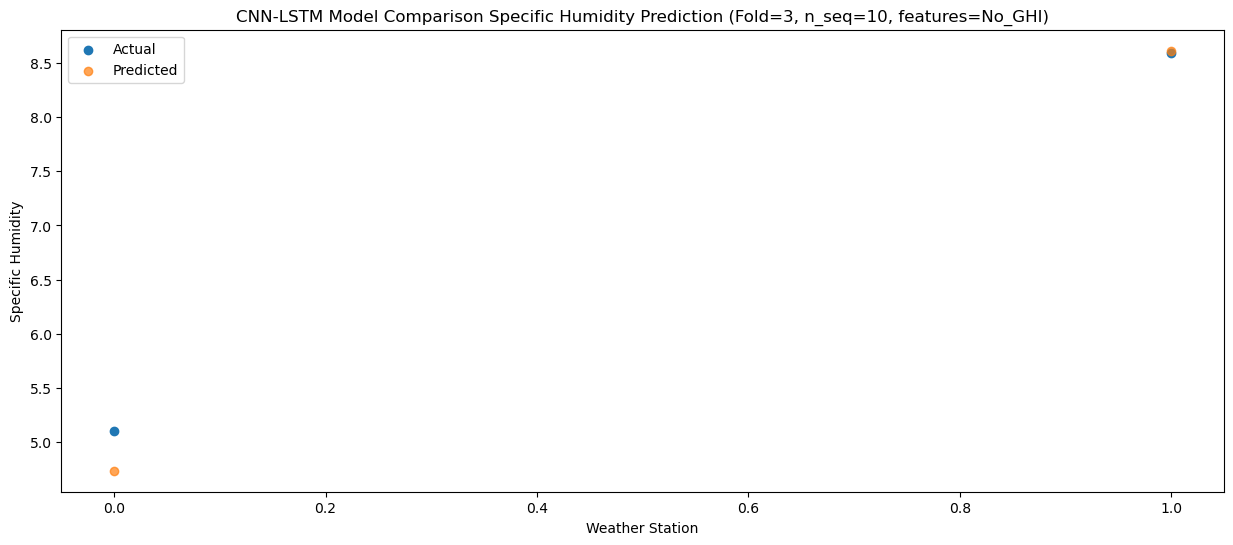

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    4.94   4.701535
1                1    8.69   8.581981


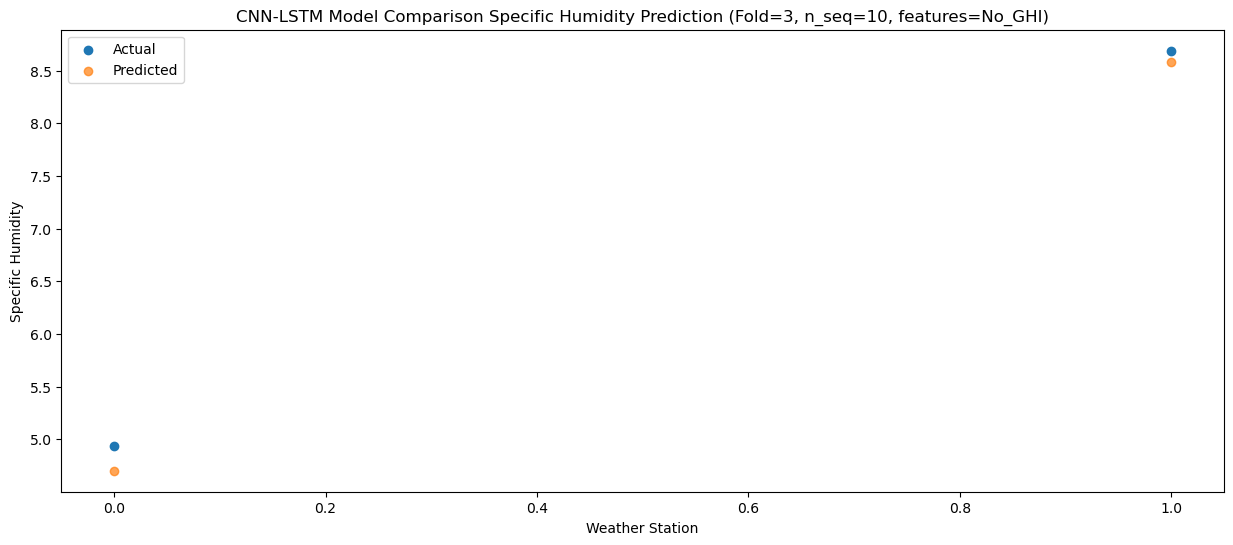

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0    5.59   4.731327
1                1    8.51   8.611670


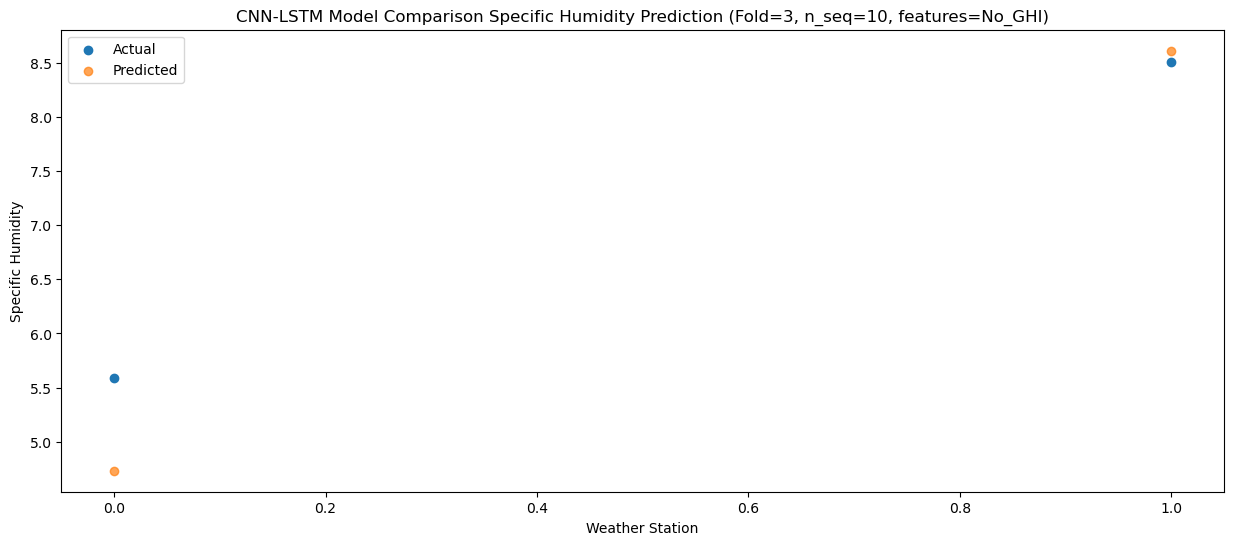

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    5.17   4.996337
1                1    8.87   8.876664


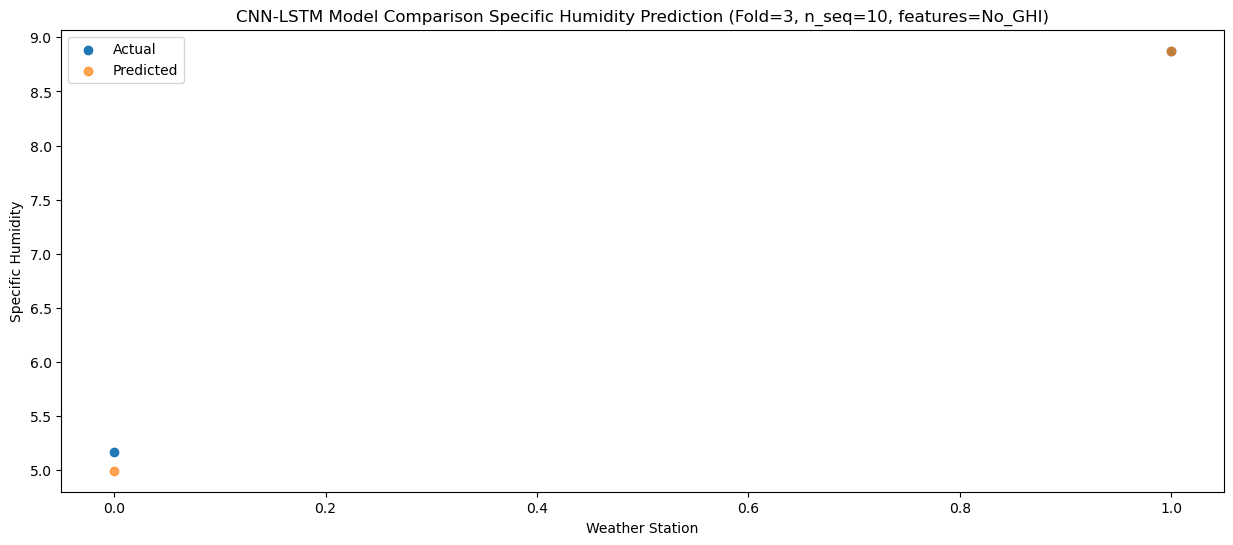

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0    5.27   4.591980
1                1    8.75   8.472191


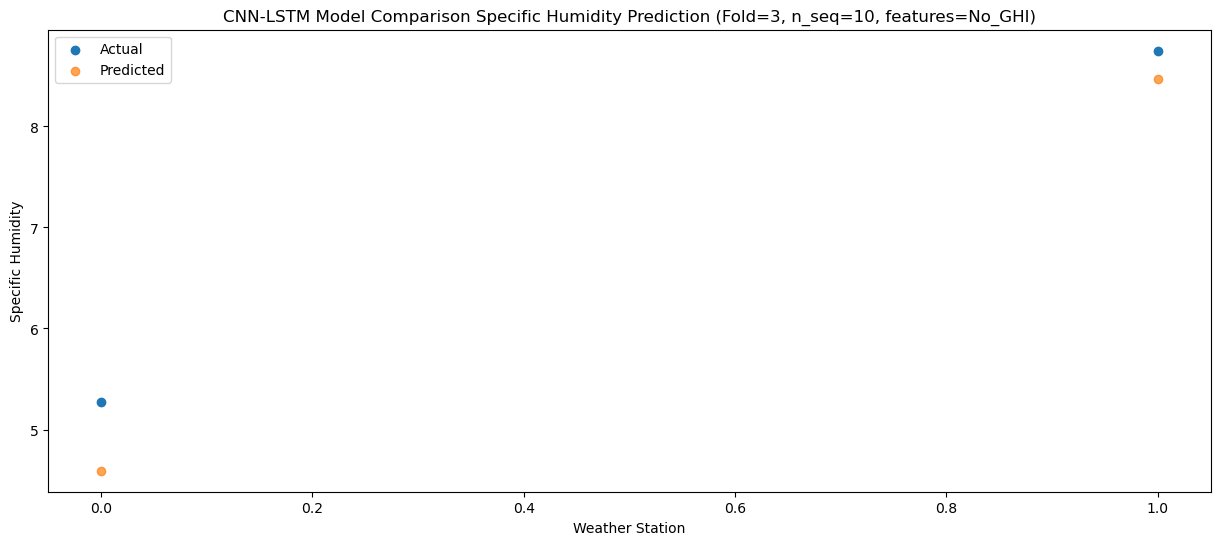

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0    5.62   4.487705
1                1    8.66   8.368138


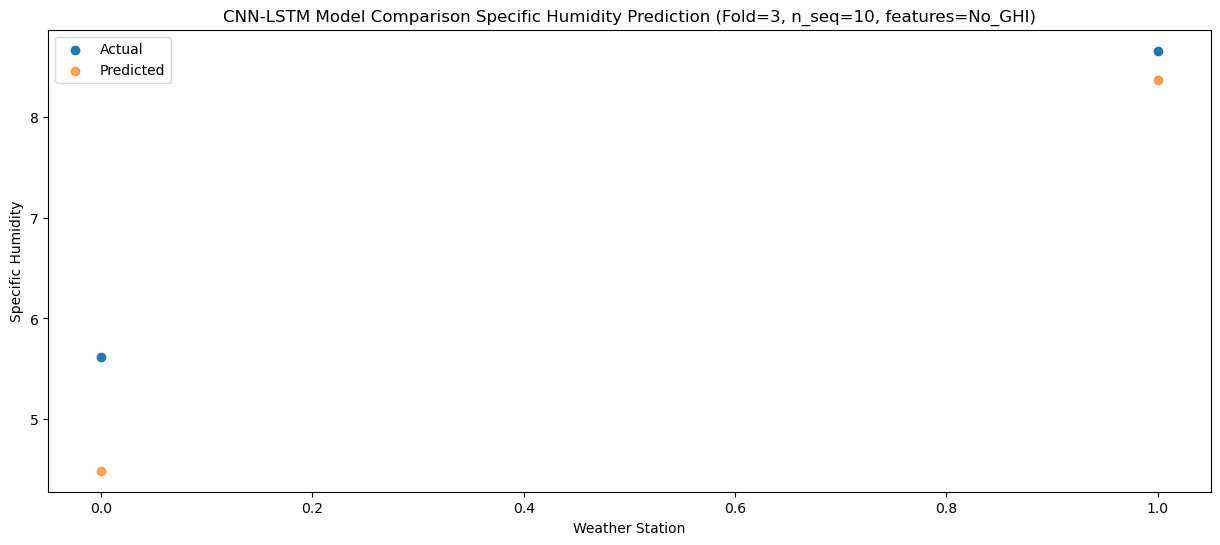

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0    5.16   4.565489
1                1    8.63   8.446189


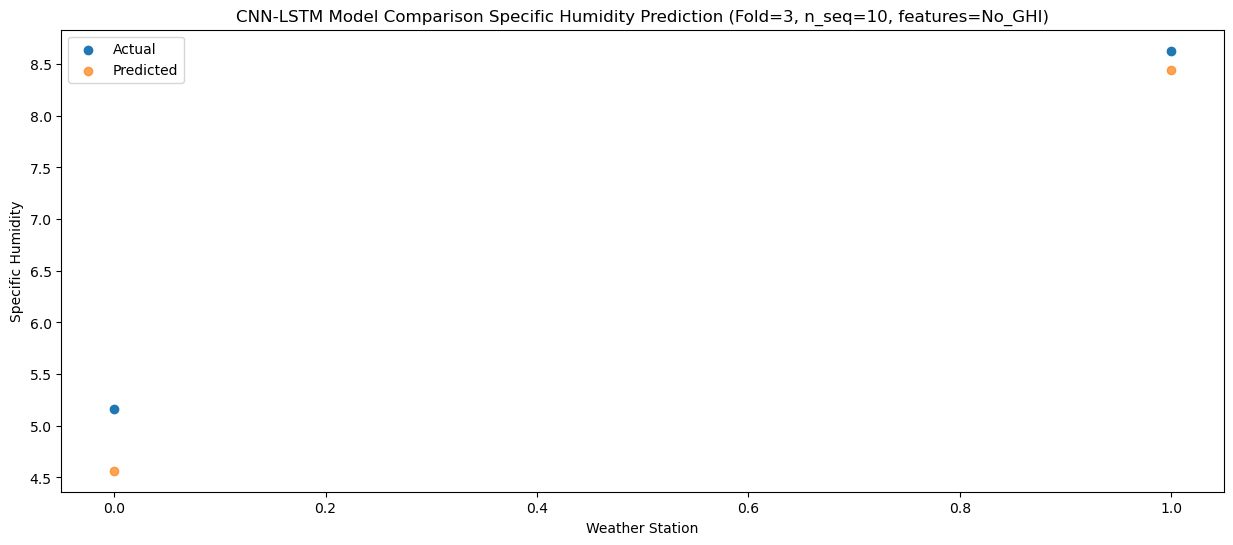

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0    4.77   4.205914
1                1    8.16   8.086702


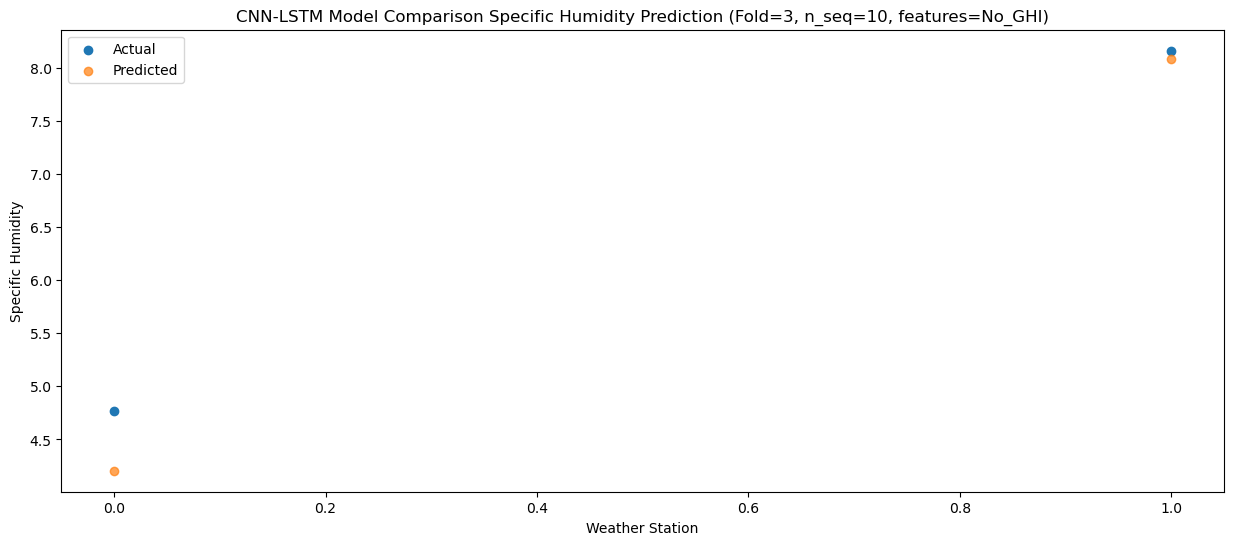

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0    5.34   4.318052
1                1    8.18   8.198863


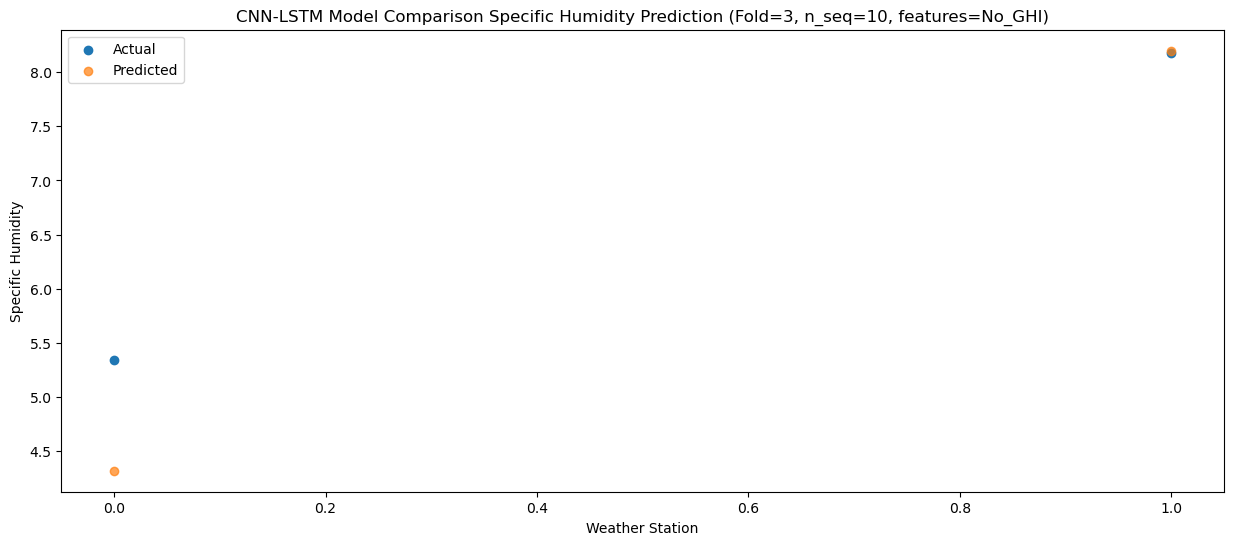

f, t:
[[4.92 7.95]
 [5.1  8.59]
 [4.94 8.69]
 [5.59 8.51]
 [5.17 8.87]
 [5.27 8.75]
 [5.62 8.66]
 [5.16 8.63]
 [4.77 8.16]
 [5.34 8.18]]
[[4.18000827 8.06011473]
 [4.7335153  8.6139081 ]
 [4.70153543 8.58198067]
 [4.7313271  8.61167023]
 [4.99633746 8.87666357]
 [4.59197988 8.4721914 ]
 [4.4877052  8.36813835]
 [4.56548853 8.44618922]
 [4.20591436 8.08670151]
 [4.31805153 8.19886282]]
Year at t+1:
t+1 SKRMSE: 0.529015
t+1 KRMSE: 0.529015
t+1 MAE: 0.425053
t+1 SKMAPE: 0.082128
t+1 R2_SCORE: 0.878070
t+1 KMAPE: 0.082128
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 6.435000
Year at t+2:
t+2 SKRMSE: 0.259695
t+2 KRMSE: 0.259695
t+2 MAE: 0.195196
t+2 SKMAPE: 0.037321
t+2 R2_SCORE: 0.977852
t+2 KMAPE: 0.037321
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 6.845000
Year at t+3:
t+3 SKRMSE: 0.185113
t+3 KRMSE: 0.185113
t+3 MAE: 0.173242
t+3 SKMAPE: 0.030351
t+3 R2_SCORE: 0.990253
t+3 KMAPE: 0.030351
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 6.815000
Year at t+4:
t+4 SKRMSE: 0.611415
t+4 KRMSE: 0.6114

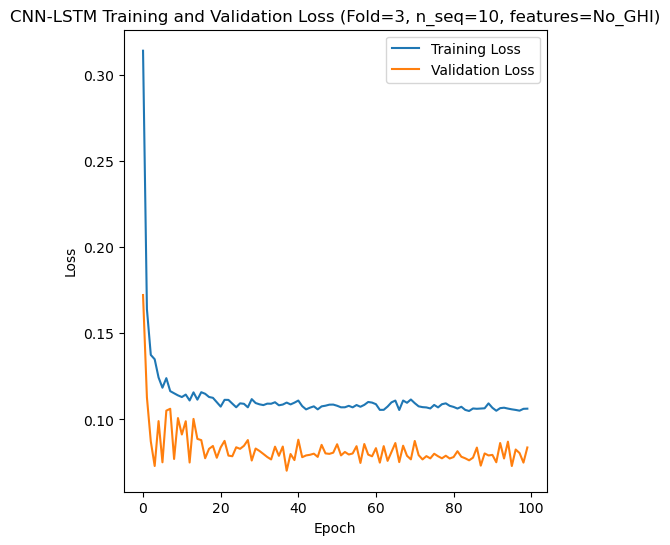

[[11.16  9.55  9.55 10.04  9.82  9.68 10.08  8.81  8.71 10.02  8.91  9.32
   9.71  8.86  9.35  8.98  8.99  9.85 10.25 10.41  9.69  9.69  9.59  9.94
   9.15  9.7  10.89]
 [ 8.33  7.32  7.52  7.52  7.95  7.22  7.21  7.13  7.15  7.14  7.22  7.24
   7.84  7.63  7.34  7.44  7.18  7.84  8.31  7.98  8.38  7.84  7.57  7.9
   7.3   7.53  8.43]]
Epoch 1/100
19/19 [==============================] - 28s 394ms/step - loss: 0.2562 - accuracy: 0.2632 - mae: 0.2301 - rmse: 0.2562 - mape: 52.9250 - pearson: 0.1778 - val_loss: 0.1487 - val_accuracy: 0.0000e+00 - val_mae: 0.1162 - val_rmse: 0.1487 - val_mape: 26.5940 - val_pearson: 0.1423
Epoch 2/100
19/19 [==============================] - 2s 108ms/step - loss: 0.1104 - accuracy: 0.3684 - mae: 0.0891 - rmse: 0.1104 - mape: 20.7383 - pearson: 0.2536 - val_loss: 0.0996 - val_accuracy: 0.3333 - val_mae: 0.0808 - val_rmse: 0.0996 - val_mape: 18.3478 - val_pearson: 0.1198
Epoch 3/100
19/19 [==============================] - 2s 103ms/step - loss: 0.0985 - acc

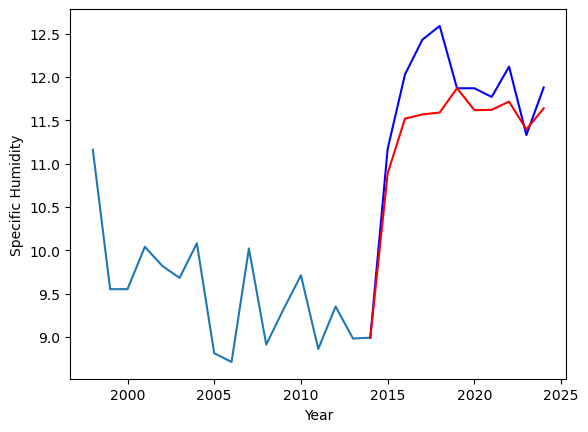

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.07		8.06		-0.01
8.73		8.69		-0.04
9.20		8.74		-0.46
8.87		8.76		-0.11
9.27		9.04		-0.23
8.73		8.79		0.06
8.46		8.79		0.33
8.79		8.89		0.10
8.19		8.56		0.37
8.42		8.81		0.39


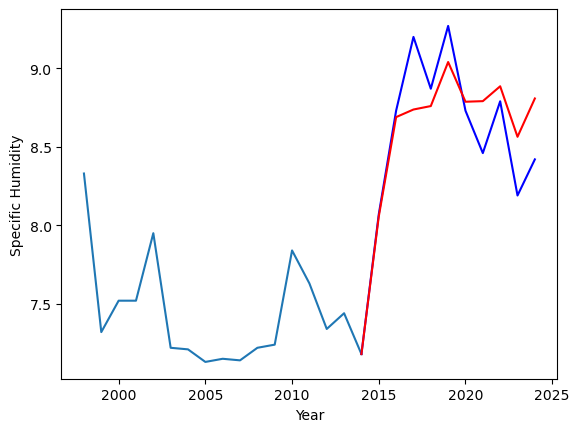

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.17  10.886464
1                1    8.07   8.056404


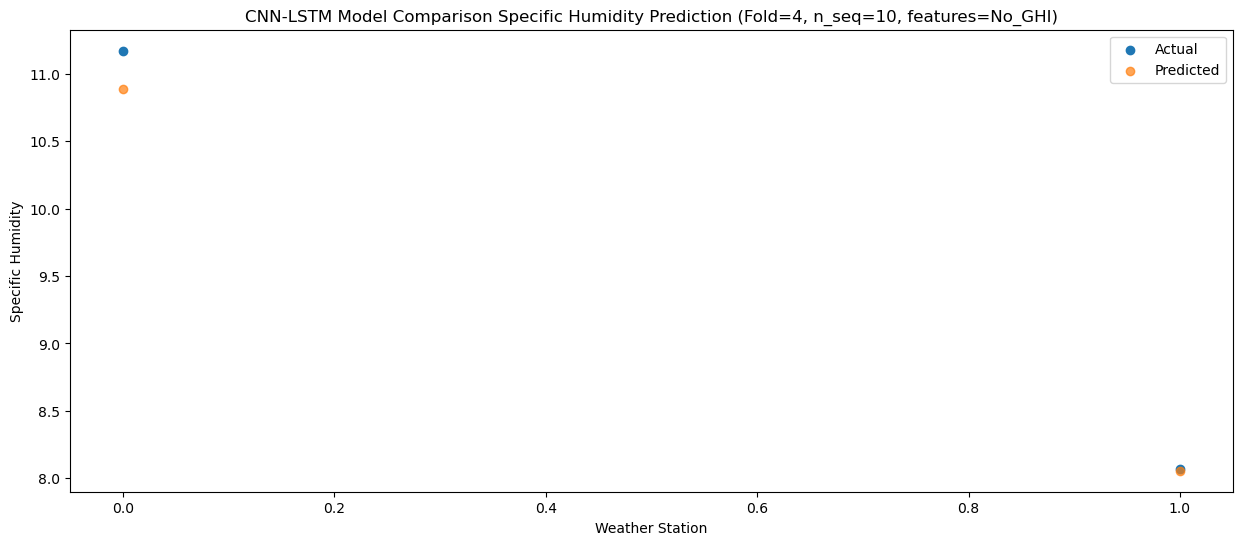

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.03  11.519445
1                1    8.73   8.689274


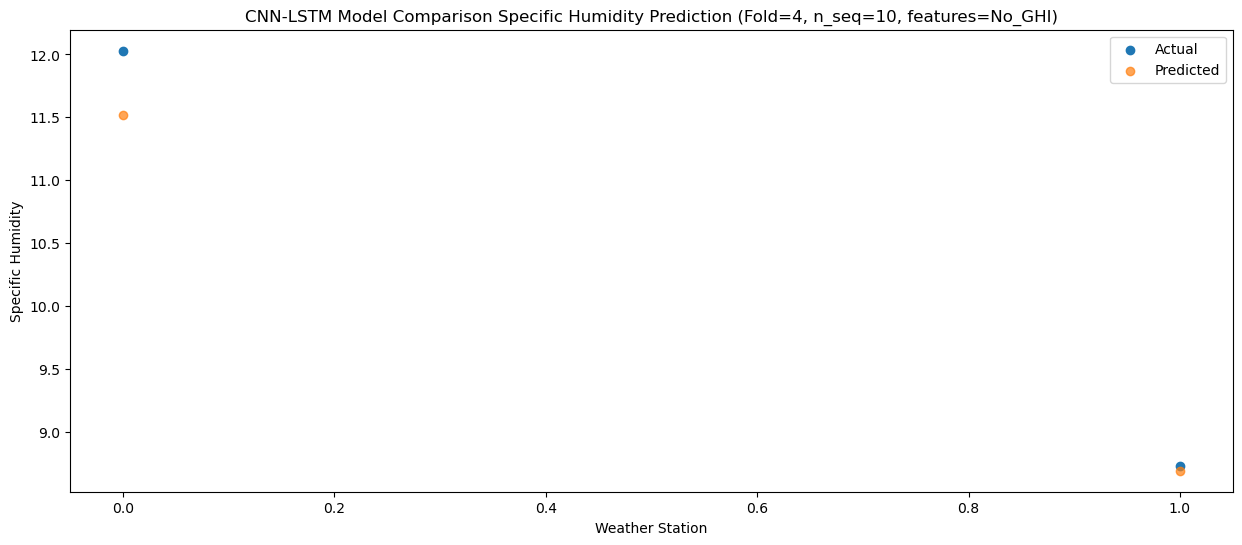

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   12.43  11.567826
1                1    9.20   8.737604


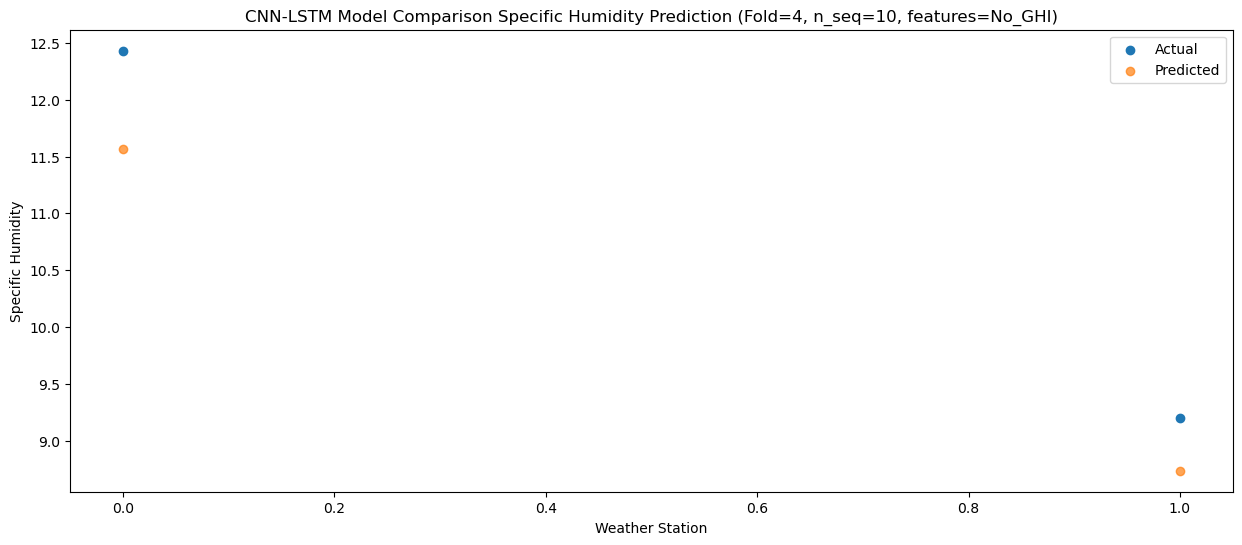

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.59  11.589848
1                1    8.87   8.759556


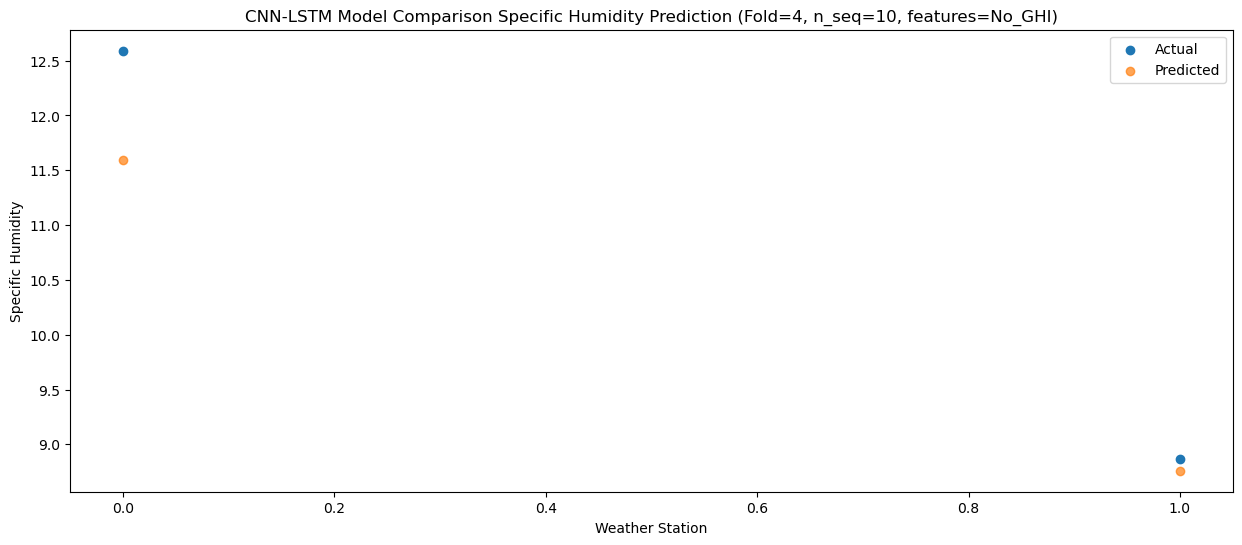

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.87  11.870471
1                1    9.27   9.040114


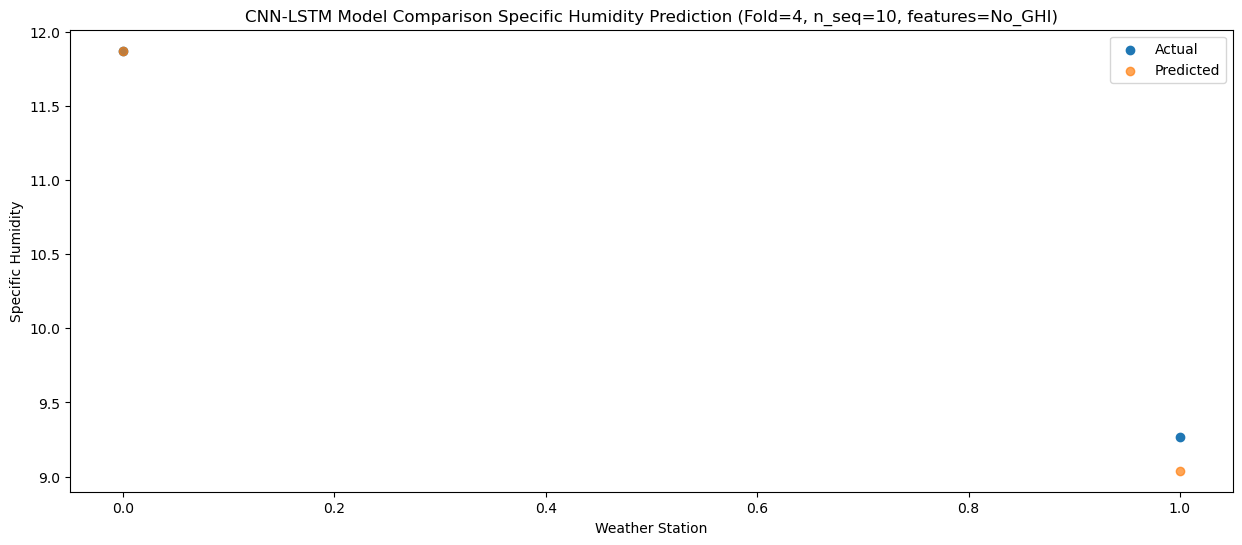

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   11.87  11.617513
1                1    8.73   8.787130


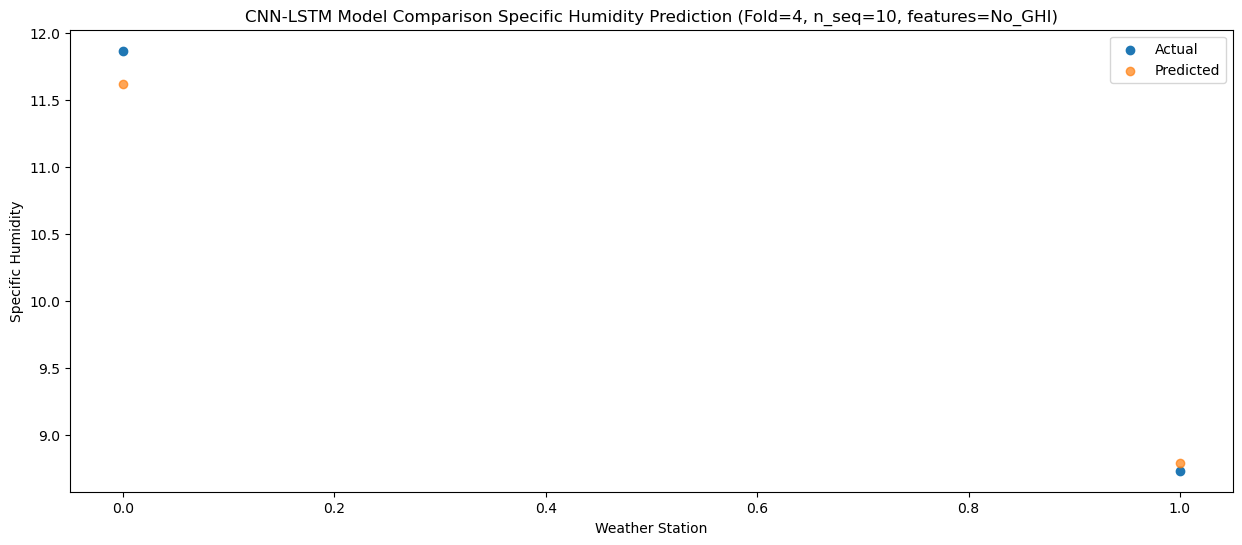

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   11.77  11.621330
1                1    8.46   8.790881


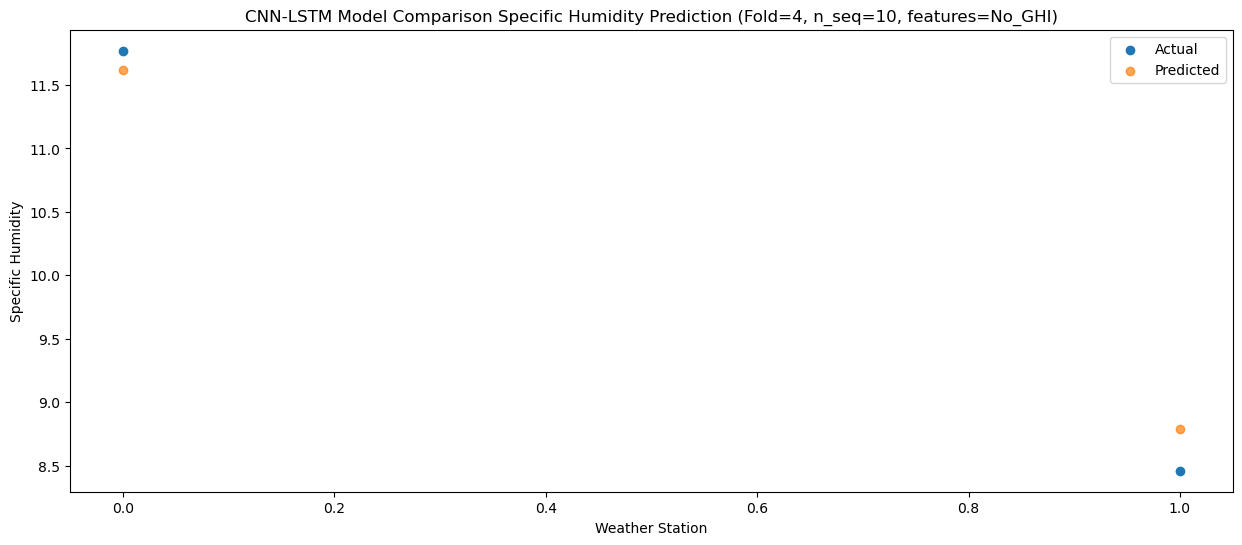

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   12.12  11.716099
1                1    8.79   8.885588


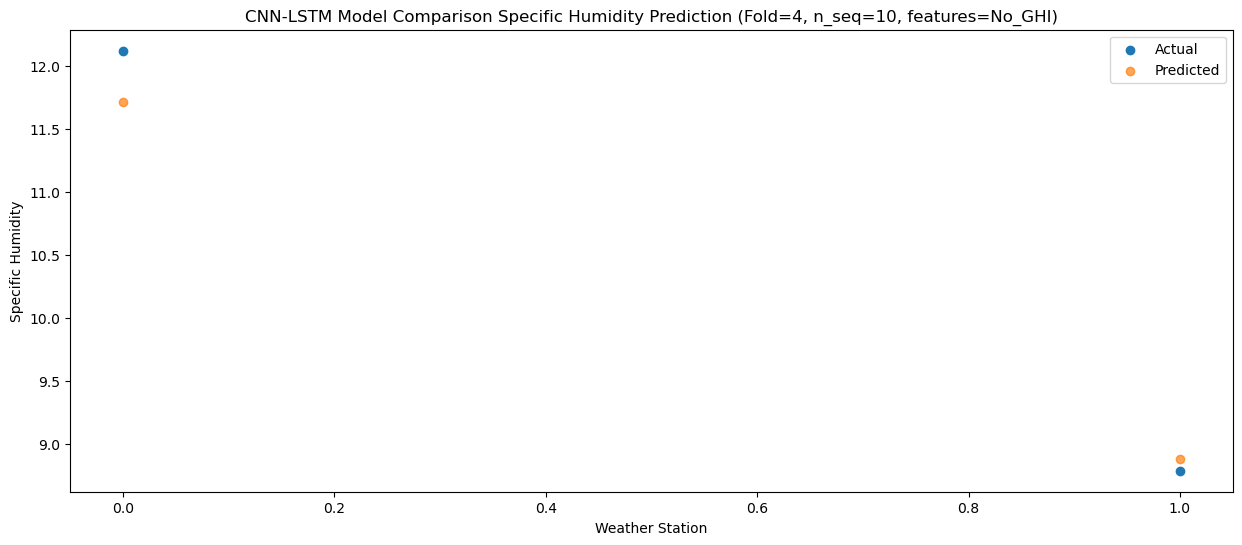

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   11.33  11.394425
1                1    8.19   8.563848


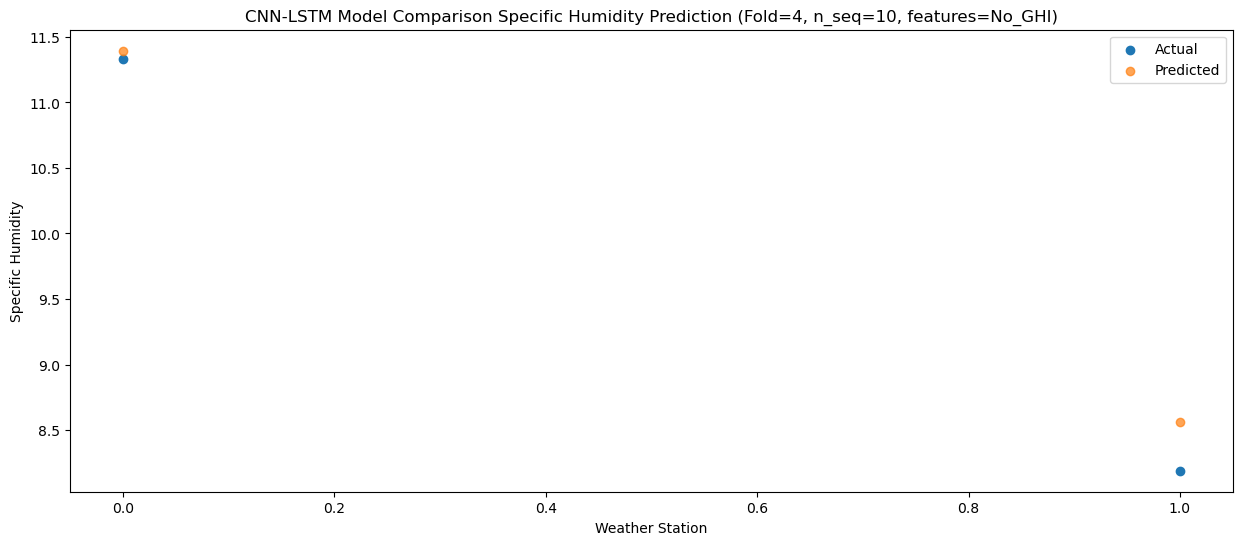

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   11.88  11.638527
1                1    8.42   8.807885


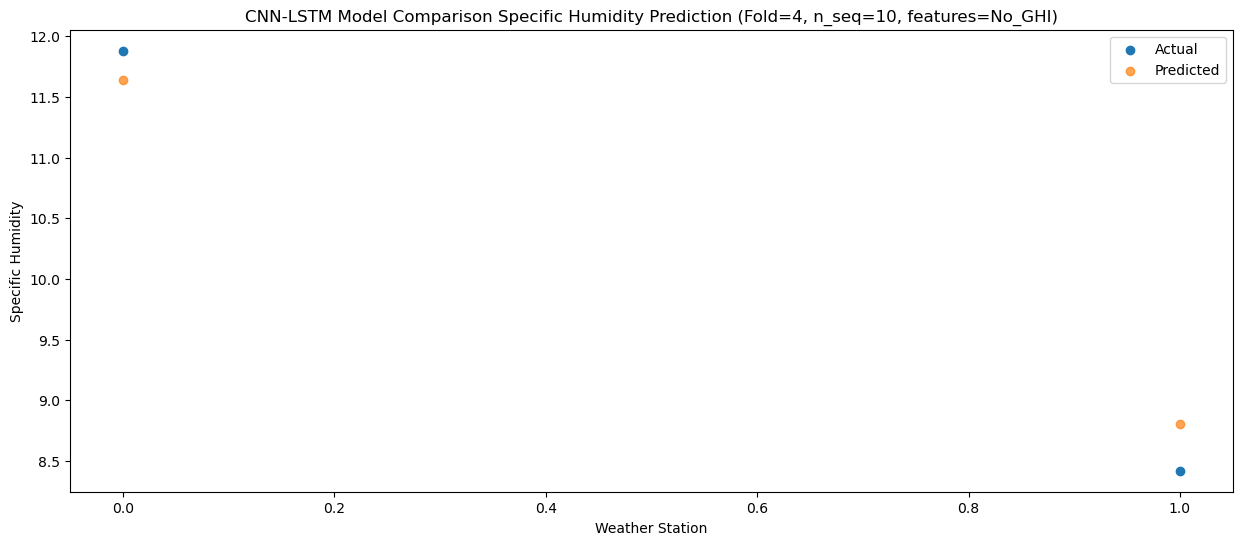

f, t:
[[11.17  8.07]
 [12.03  8.73]
 [12.43  9.2 ]
 [12.59  8.87]
 [11.87  9.27]
 [11.87  8.73]
 [11.77  8.46]
 [12.12  8.79]
 [11.33  8.19]
 [11.88  8.42]]
[[10.88646353  8.05640431]
 [11.51944518  8.68927403]
 [11.56782617  8.73760385]
 [11.58984761  8.75955608]
 [11.87047078  9.04011401]
 [11.61751341  8.7871297 ]
 [11.62132967  8.79088125]
 [11.71609868  8.88558762]
 [11.39442541  8.56384774]
 [11.63852659  8.80788504]]
Year at t+1:
t+1 SKRMSE: 0.200721
t+1 KRMSE: 0.200721
t+1 MAE: 0.148566
t+1 SKMAPE: 0.013534
t+1 R2_SCORE: 0.983230
t+1 KMAPE: 0.013534
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.620000
Year at t+2:
t+2 SKRMSE: 0.362164
t+2 KRMSE: 0.362164
t+2 MAE: 0.275640
t+2 SKMAPE: 0.023553
t+2 R2_SCORE: 0.951823
t+2 KMAPE: 0.023553
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 10.380000
Year at t+3:
t+3 SKRMSE: 0.691793
t+3 KRMSE: 0.691793
t+3 MAE: 0.662285
t+3 SKMAPE: 0.059811
t+3 R2_SCORE: 0.816512
t+3 KMAPE: 0.059811
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 10.815000
Year at t

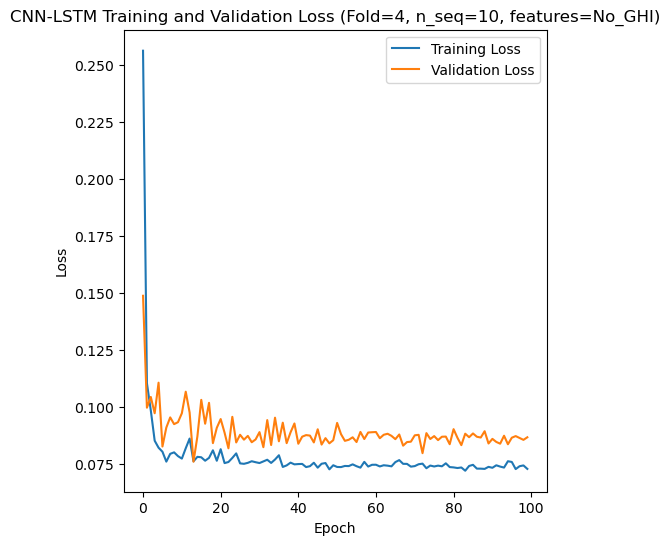

[[0.41704541144888063], [0.5541446848021886], [0.4483610175967971], [0.5099353841623118], [0.3929984576495963]]
[[array(0.41704541)], [array(0.55414468)], [array(0.44836102)], [array(0.50993538)], [array(0.39299846)]]
[[0.32321180252358345], [0.43281175972148783], [0.3407091521769762], [0.37820776207745094], [0.29351122044026845]]
[[0.026515548604367722], [0.04353357328032706], [0.035945689670337184], [0.06762596306168858], [0.027600515365462052]]
[[0.927151191967025], [0.9158190530217], [0.8319201988918411], [0.9076505660781383], [0.9442020814186345]]
[[array(0.02651555)], [array(0.04353357)], [array(0.03594569)], [array(0.06762596)], [array(0.02760052)]]
[[array(0.95422557)], [array(0.96346504)], [array(0.91683397)], [array(0.98211621)], [array(0.96824597)]]
[12.78 13.83 13.92 14.3  13.46 13.41 13.53 13.34 13.05 13.36  9.71 10.79
 10.2  10.87 10.99 10.8  11.01 10.57 10.05 10.24 11.42 12.26 11.81 12.26
 12.81 12.14 12.5  11.83 11.88 11.74  7.95  9.08  9.06  8.69  8.53  8.56
  7.82  8.

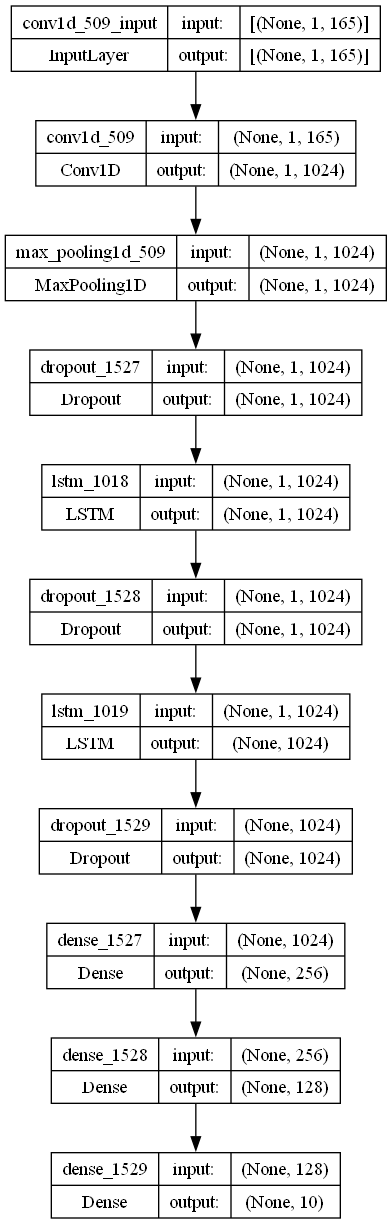

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best CNN-LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 1024
    lr = 0.0016238629162217508
    optimizer = Adam(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 1024
    dropout_rate = 0.1051800505971675
    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

   
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (specific_humidity)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_SH_S10_No_GHI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)